### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np 

import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

!pip install pmdarima
!pip install plotly
!pip install -U kaleido
pd.set_option('mode.chained_assignment', None)


Requirement already up-to-date: kaleido in /Users/teja/opt/anaconda3/lib/python3.7/site-packages (0.0.3.post1)


In [2]:
import os

if not os.path.exists("../images"):
    os.mkdir("../images")

#### Read COVID data

In [3]:
# read data from covid_large csv file
covid_large_df = pd.read_csv("../data/covid_large.csv")
covid_large_df.head()

State  countyFIPS            County Name        Date  Num of Cases  \
0    AL           0  statewide unallocated  2020-01-22             0   
1    AL           0  statewide unallocated  2020-01-23             0   
2    AL           0  statewide unallocated  2020-01-24             0   
3    AL           0  statewide unallocated  2020-01-25             0   
4    AL           0  statewide unallocated  2020-01-26             0   

   Num of Deaths  population  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0

In [4]:
# Converting 'Date' column to Date type
covid_large_df['Date'] = covid_large_df.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

# Extracting California State data
COVID_CA = covid_large_df.loc[(covid_large_df["State"].isin(["CA"]))]

COVID_CA.head()

State  countyFIPS            County Name       Date  Num of Cases  \
45267    CA           0  statewide unallocated 2020-01-22             0   
45268    CA           0  statewide unallocated 2020-01-23             0   
45269    CA           0  statewide unallocated 2020-01-24             0   
45270    CA           0  statewide unallocated 2020-01-25             0   
45271    CA           0  statewide unallocated 2020-01-26             0   

       Num of Deaths  population  
45267              0           0  
45268              0           0  
45269              0           0  
45270              0           0  
45271              0           0

#### Getting new cases and new deaths using diff()

In [5]:
COVID_CA['NumofNewCasesPerDay'] = COVID_CA['Num of Cases'].diff()
COVID_CA['NumofNewDeathsPerDay'] = COVID_CA['Num of Deaths'].diff()

# Cleaning data by changing negative values to 0
COVID_CA['NumofNewCasesPerDay'][COVID_CA['NumofNewCasesPerDay'] < 0] = 0
COVID_CA['NumofNewCasesPerDay'][COVID_CA['NumofNewCasesPerDay'] < 0] = 0

# Removing 1st date for every state
COVID_CA= COVID_CA[COVID_CA['Date'] != '2020-01-22']

# Number of new cases and new deaths per day
COVID_CA_date = COVID_CA.groupby("Date").sum().reset_index()

COVID_CA_cleaned = COVID_CA_date.drop(['countyFIPS','Num of Cases','Num of Deaths'],axis=1)

COVID_CA_cleaned.head()

Date  population  NumofNewCasesPerDay  NumofNewDeathsPerDay
0 2020-01-23    39512223                  0.0                   0.0
1 2020-01-24    39512223                  0.0                   0.0
2 2020-01-25    39512223                  0.0                   0.0
3 2020-01-26    39512223                  2.0                   0.0
4 2020-01-27    39512223                  1.0                   0.0

#### Method to get list of days since first occurence of new case or death

In [6]:
# Taking parameters as first_occurence of case or death and dataframe
def getDaysSinceFirstOcc(first_occurence,df):
    numOfSinceDay1=[]
    counter=1
    # Adds counter to the list from the first_occurence until end of dataframe
    for i,index in enumerate(range(len(df))):
        if i<=first_occurence:
            numOfSinceDay1.insert(index, 0) 
        else:
            numOfSinceDay1.insert(index, counter) 
            counter = counter+1
    return numOfSinceDay1 

#### Method to perform Linear Regression (degree=1), Polynomial Regression ( degree = 2-5) and calculate R2 , RMSE and plot the predictions

In [7]:
# Takes parameters as dataframe, x_values is the "days"(since 1st occurence) 
# and y_values is "new cases" or "new deaths"
# Measures is boolean which prints RMSE, R2 if TRUE
def getPRPlots(df,x_values,y_values,measures,title):
    models = []
    X = df[x_values].values.reshape(-1, 1)
    x_range = np.linspace(X.min(), X.max(), len(df)).reshape(-1, 1)

    fig = px.scatter(df, x=x_values, y=y_values, opacity=0.65, title=title)
    
    # Regression for all degrees (1-5)
    for degree in [1,2,3,4,5]:
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, df[y_values])
        y_poly = model.predict(x_range_poly)
        
        # Adding all models into array
        models.append(model)
        
        # Plotting all regression degrees 
        fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))

        # RMSE and R2 measures
        if measures:
            print("RMSE for degree ",degree,": ",np.sqrt(mean_squared_error(df[y_values].values,y_poly)))
            print("R2 for degree ",degree,": ",r2_score(df[y_values].values,y_poly))
            print("")

            
    return {"fig" : fig, "models" : models}

### Predicting for State - California

#### Linear (degree = 1) and Polynomial Regression for New cases

RMSE for degree  1 :  2186.2606190132074
R2 for degree  1 :  0.5841785851636749

RMSE for degree  2 :  2181.821681408233
R2 for degree  2 :  0.5858654210853195

RMSE for degree  3 :  1793.6287171697875
R2 for degree  3 :  0.7201224360232359

RMSE for degree  4 :  1553.927827715614
R2 for degree  4 :  0.789929690105961

RMSE for degree  5 :  1543.8063816682925
R2 for degree  5 :  0.7926573467721689



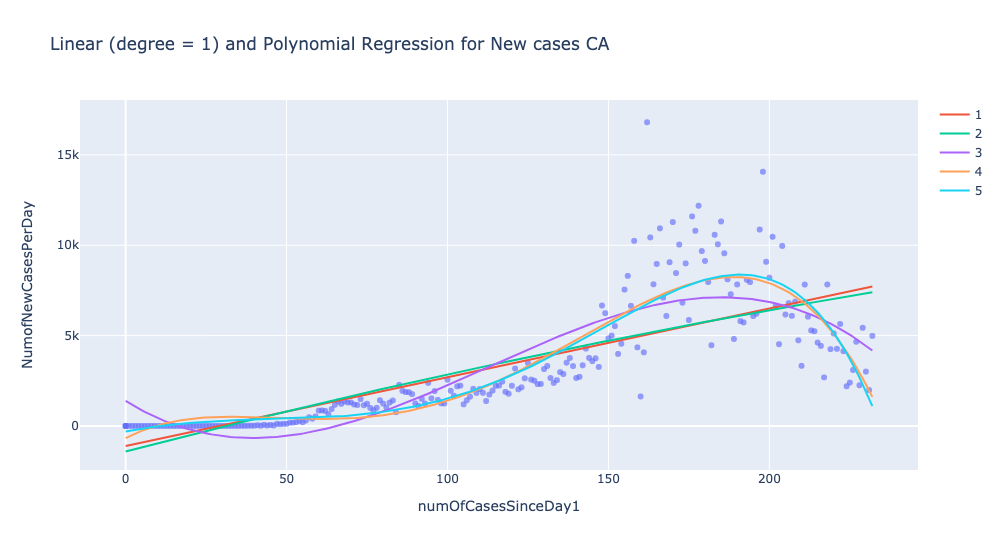

In [8]:
# Find first occurence of new case
first_case_index = COVID_CA_cleaned['NumofNewCasesPerDay'].ne(0).idxmax() 
# Find first occurence of new death
first_death_index= COVID_CA_cleaned['NumofNewDeathsPerDay'].ne(0).idxmax()

# Adding columns for days of 1st occurence of cases and deaths
COVID_CA_cleaned["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_case_index, COVID_CA_cleaned)
COVID_CA_cleaned["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index, COVID_CA_cleaned)

# Plotting Linear (degree = 1) and Polynomial Regression for new cases in California 
fig = getPRPlots(COVID_CA_cleaned,"numOfCasesSinceDay1",'NumofNewCasesPerDay',True, "Linear (degree = 1) and Polynomial Regression for New cases CA")["fig"]
# fig.show()
fig.write_image("../images/newcases_prediction_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)



#### Plotting Linear (degree = 1) and Polynomial Regression for new deaths in California 

RMSE for degree  1 :  39.933938525245495
R2 for degree  1 :  0.5057988191233862

RMSE for degree  2 :  39.80398035363759
R2 for degree  2 :  0.5090101716129815

RMSE for degree  3 :  39.60817914698749
R2 for degree  3 :  0.5138287825140557

RMSE for degree  4 :  39.63270616302126
R2 for degree  4 :  0.5132264815993838

RMSE for degree  5 :  37.91838916174111
R2 for degree  5 :  0.5544266088129897



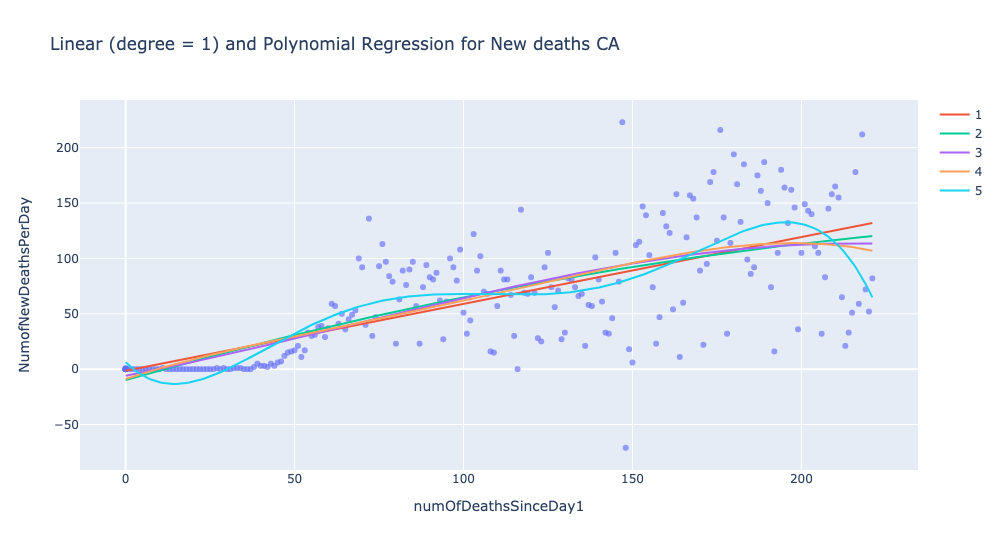

In [9]:
# Plotting Linear (degree = 1) and Polynomial Regression for new deaths in California 
fig1 = getPRPlots(COVID_CA_cleaned,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',True, "Linear (degree = 1) and Polynomial Regression for New deaths CA")["fig"]
fig1.write_image("../images/newdeaths_prediction_ca.png")
img_bytes = fig1.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new cases of degree 3 based on RMSE and R2 values

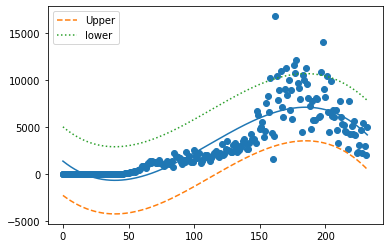

In [10]:
X = COVID_CA_cleaned["numOfCasesSinceDay1"].values.reshape(-1,1)
y = COVID_CA_cleaned["NumofNewCasesPerDay"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')


#### Confidence Interval for new deaths of degree 5 based on RMSE and R2 values

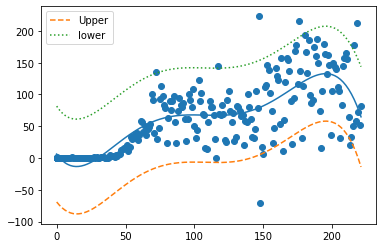

In [11]:
X = COVID_CA_cleaned["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = COVID_CA_cleaned["NumofNewDeathsPerDay"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=5)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')


#### Predicting future cases for 1 week using Polynomial Regression

Based on RMSE and R2 values degree 3 for cases fits better

In [12]:
# X values for 7 future days
future_cases = np.arange(COVID_CA_cleaned["numOfCasesSinceDay1"][len(COVID_CA_cleaned)-1], COVID_CA_cleaned["numOfCasesSinceDay1"][len(COVID_CA_cleaned)-1] + 7).reshape(-1,1)

# Predicting for future cases for 1 week
poly = PolynomialFeatures(degree = 3)
model = getPRPlots(COVID_CA_cleaned,"numOfCasesSinceDay1",'NumofNewCasesPerDay',False, "Prediction Path future cases for 1 week CA")["models"][2]
poly_features = poly.fit_transform(future_cases)
pred = model.predict(poly_features)
pred

array([4177.20914445, 4038.60368224, 3896.33913427, 3750.38516767,
       3600.71144956, 3447.28764708, 3290.08342736])

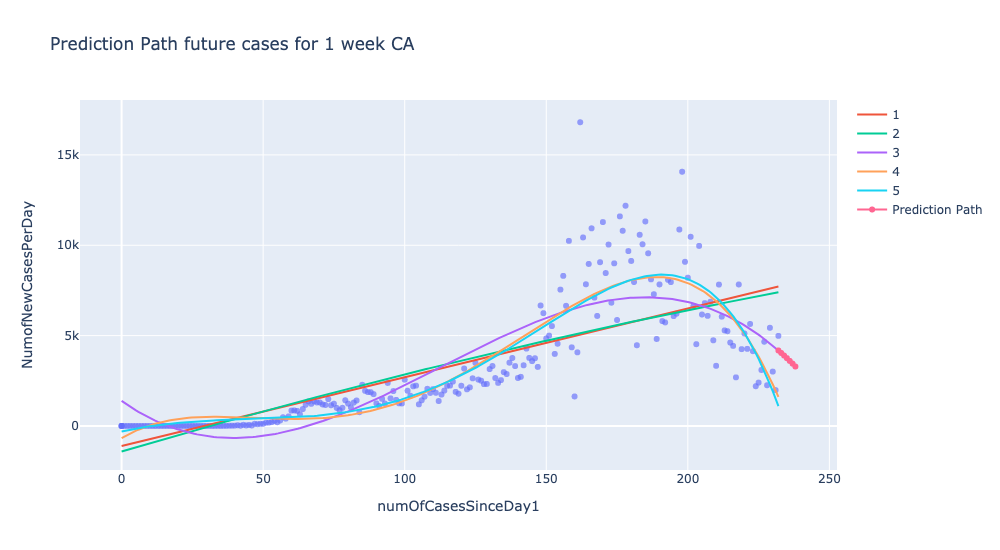

In [13]:
fig = getPRPlots(COVID_CA_cleaned,"numOfCasesSinceDay1",'NumofNewCasesPerDay',False, "Prediction Path future cases for 1 week CA")["fig"]
fig.add_traces(go.Scatter(x=future_cases.squeeze(), y=pred, name='Prediction Path'))
fig.write_image("../images/newcases_predpath_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Predicting future deaths for 1 week using Polynomial Regression

Based on RMSE and R2 values degree 5 for deaths fits better

In [14]:
# X values for 7 future days
future_deaths = np.arange(COVID_CA_cleaned["numOfDeathsSinceDay1"][len(COVID_CA_cleaned)-1],COVID_CA_cleaned["numOfDeathsSinceDay1"][len(COVID_CA_cleaned)-1] + 7).reshape(-1,1)

# Predicting for future deaths for 1 week
poly = PolynomialFeatures(degree = 5)
model = getPRPlots(COVID_CA_cleaned,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False, "Prediction Path of future deaths for 1 week CA")["models"][4]
poly_features = poly.fit_transform(future_deaths)
pred = model.predict(poly_features)
pred

array([64.82830482, 58.20589109, 51.17461296, 43.72067632, 35.83002198,
       27.48832337, 18.68098428])

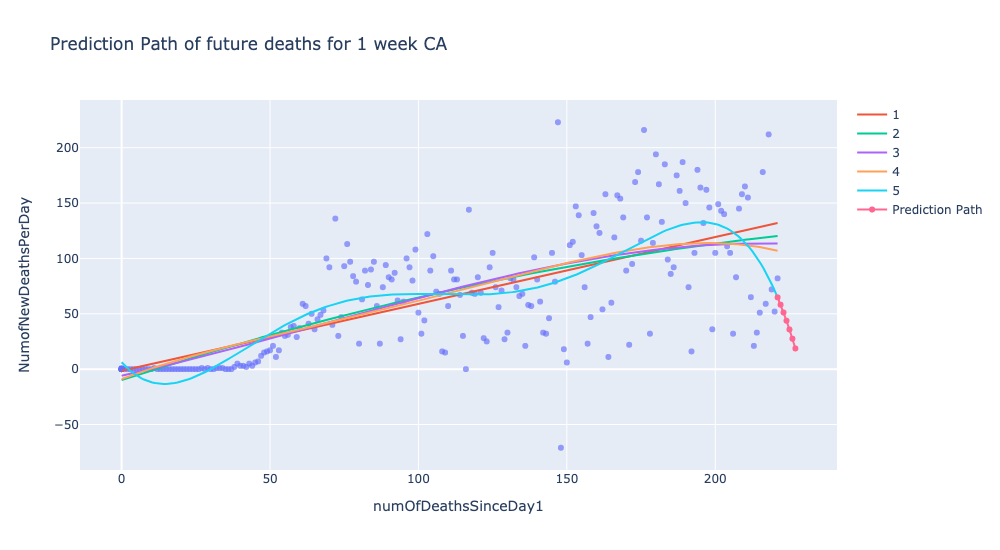

In [15]:
fig = getPRPlots(COVID_CA_cleaned,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False, "Prediction Path of future deaths for 1 week CA")["fig"]
fig.add_traces(go.Scatter(x=future_deaths.squeeze(), y=pred, name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

<b>From above observations we can see that for California state the number of new cases and deaths are gradually decreasing</b>

### Predicting for 5 counties (imperial, kings, kern, tulare, merced) in California (top 5 counties with high cases from stage2)

#### Extracting 5 counties and normalizind new cases and deaths data

In [16]:
COVID_CA_countys = COVID_CA.loc[(COVID_CA["countyFIPS"].isin([6025, 6031, 6029, 6107, 6047]))]

# Normalizing new cases and deaths by county population
COVID_CA_countys['NumofNewCasesNormalized']= (COVID_CA_countys['NumofNewCasesPerDay']/(COVID_CA_countys["population"]))*1000000
COVID_CA_countys['NumofNewDeathsNormalized']= (COVID_CA_countys['NumofNewDeathsPerDay']/(COVID_CA_countys["population"]))*1000000
COVID_CA_countys.head()


State  countyFIPS      County Name       Date  Num of Cases  \
48586    CA        6025  imperial county 2020-01-23             0   
48587    CA        6025  imperial county 2020-01-24             0   
48588    CA        6025  imperial county 2020-01-25             0   
48589    CA        6025  imperial county 2020-01-26             0   
48590    CA        6025  imperial county 2020-01-27             0   

       Num of Deaths  population  NumofNewCasesPerDay  NumofNewDeathsPerDay  \
48586              0      181215                  0.0                   0.0   
48587              0      181215                  0.0                   0.0   
48588              0      181215                  0.0                   0.0   
48589              0      181215                  0.0                   0.0   
48590              0      181215                  0.0                   0.0   

       NumofNewCasesNormalized  NumofNewDeathsNormalized  
48586                      0.0                       0.0  
48587                      0.0                       0.0  
48588                      0.0                       0.0  
48589                      0.0                       0.0  
48590                      0.0                       0.0

### Imperial County

#### Linear (degree = 1) and Polynomial Regression for New cases and New deaths for "Imperial county"

RMSE for degree  1 :  429.9415107344484
R2 for degree  1 :  0.10485938360237768

RMSE for degree  2 :  435.57117846081064
R2 for degree  2 :  0.08126390943488304

RMSE for degree  3 :  415.3221380661023
R2 for degree  3 :  0.16469963870987947

RMSE for degree  4 :  429.4115991127137
R2 for degree  4 :  0.10706458167566446

RMSE for degree  5 :  420.82259745167687
R2 for degree  5 :  0.14242796121926693



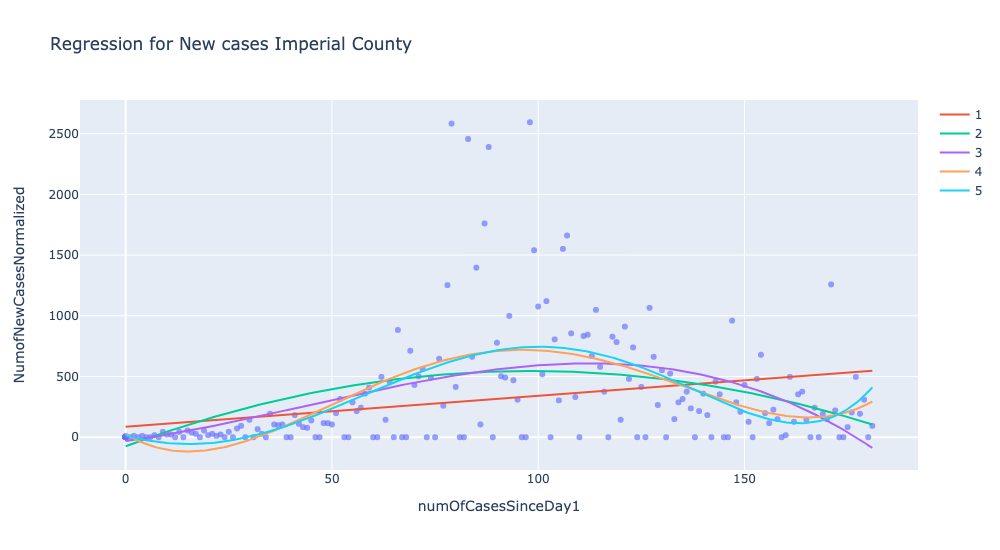

In [17]:
imperial_county = COVID_CA_countys[COVID_CA_countys["countyFIPS"] == 6025].reset_index()

# Find first occurence of new case
first_case_index = imperial_county['NumofNewCasesNormalized'].ne(0).idxmax() 
# Find first occurence of new death
first_death_index= imperial_county['NumofNewDeathsNormalized'].ne(0).idxmax()

# Adding columns for days of 1st occurence of cases and deaths
imperial_county["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_case_index, imperial_county)
imperial_county["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index, imperial_county)

# Plotting Linear (degree = 1) and Polynomial Regression for new cases in Imperial County 
fig = getPRPlots(imperial_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',True, "Regression for New cases Imperial County")["fig"]
fig.write_image("../images/newcases_pred_imperial_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

RMSE for degree  1 :  12.775158944255447
R2 for degree  1 :  0.14655649657901426

RMSE for degree  2 :  13.324656074948608
R2 for degree  2 :  0.07155930325615723

RMSE for degree  3 :  12.75555905631632
R2 for degree  3 :  0.14917322571085123

RMSE for degree  4 :  12.781863583845512
R2 for degree  4 :  0.1456604556546317

RMSE for degree  5 :  12.87099916477102
R2 for degree  5 :  0.13370326678359268



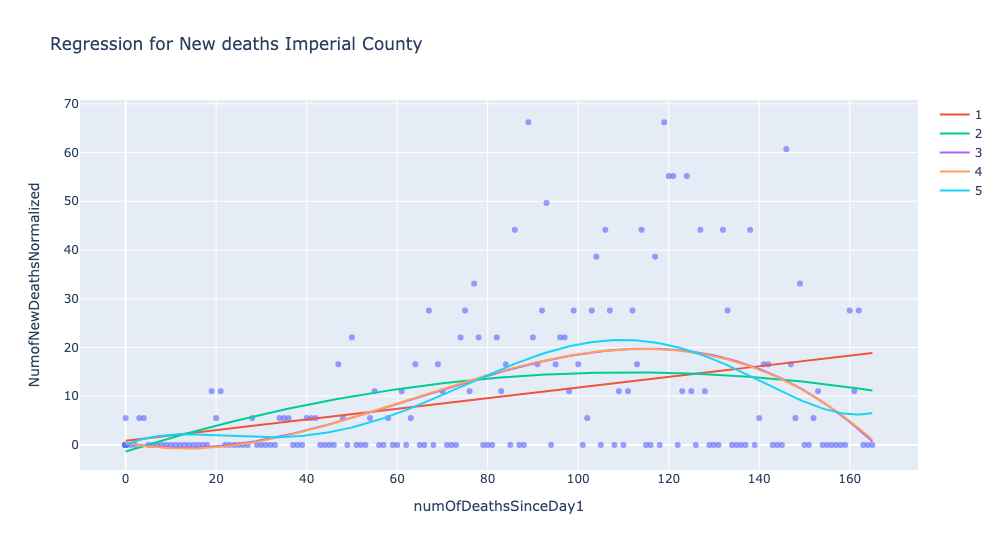

In [18]:
# Plotting Linear (degree = 1) and Polynomial Regression for new deaths in Imperial County  
fig = getPRPlots(imperial_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',True, "Regression for New deaths Imperial County")["fig"]
fig.write_image("../images/newdeaths_pred_imperial_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new cases of degree 3 based on RMSE and R2 values Imperial County

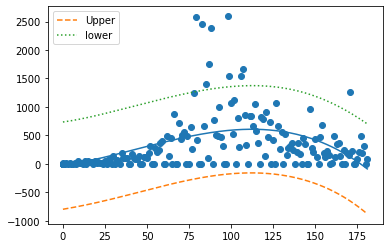

In [19]:
X = imperial_county["numOfCasesSinceDay1"].values.reshape(-1,1)
y = imperial_county["NumofNewCasesNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Confidence Interval for new deaths of degree 3 based on RMSE and R2 values Imperial CountyÂ¶

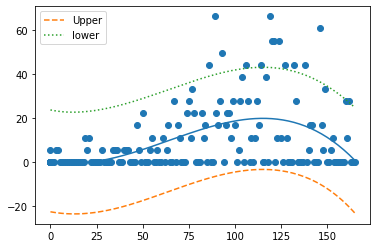

In [20]:
X = imperial_county["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = imperial_county["NumofNewDeathsNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting future cases for 1 week using Polynomial Regression for "Imperial County"

Based on RMSE and R2 values degree 3 for cases and deaths fits better

Cases Prediction :  [ -88.4433743  -111.49864744 -135.00059849 -158.95245394 -183.35744028
 -208.21878402 -233.53971163]


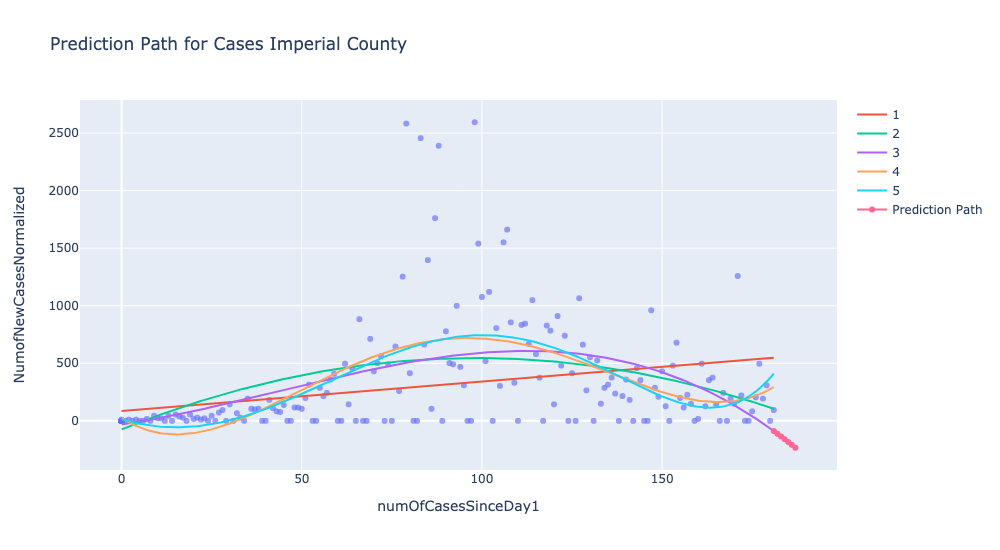

In [21]:
# X values for 7 future days
future_cases_im = np.arange(imperial_county["numOfCasesSinceDay1"][len(imperial_county)-1], imperial_county["numOfCasesSinceDay1"][len(imperial_county)-1] + 7).reshape(-1,1)
future_deaths_im = np.arange(imperial_county["numOfDeathsSinceDay1"][len(imperial_county)-1], imperial_county["numOfDeathsSinceDay1"][len(imperial_county)-1] + 7).reshape(-1,1)

# Predicting for future cases for 1 week
poly = PolynomialFeatures(degree = 3)
model = getPRPlots(imperial_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path for Cases Imperial County")["models"][2]
poly_features = poly.fit_transform(future_cases_im)
print("Cases Prediction : ", model.predict(poly_features))

fig = getPRPlots(imperial_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path for Cases Imperial County")["fig"]
fig.add_traces(go.Scatter(x=future_cases_im.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newcases_predpath_imperial_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Prediction Path for Deaths Imperial County

Deaths Prediction :  [ 0.71768466 -0.15212916 -1.04503053 -1.96124556 -2.90100034 -3.86452098
 -4.85203358]


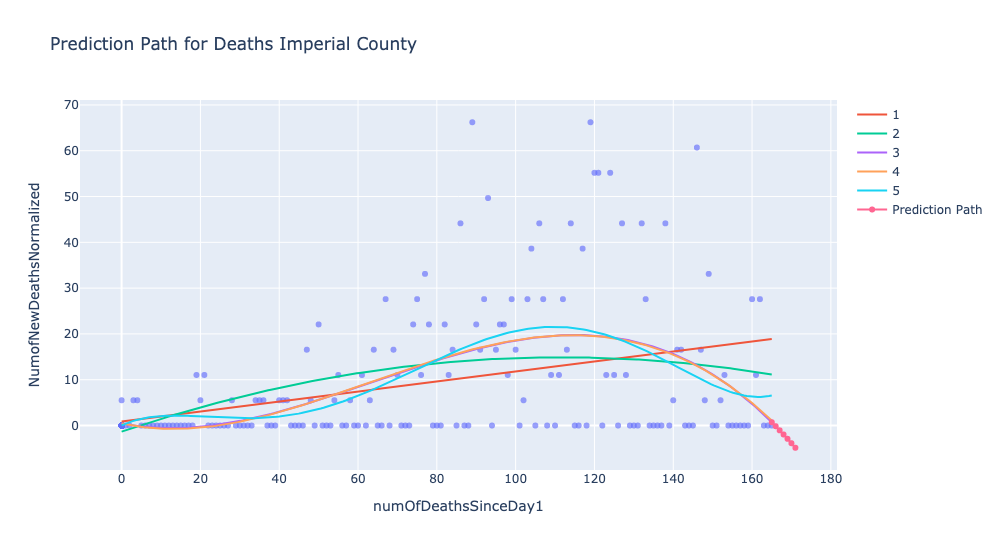

In [22]:
# Predicting for future deaths for 1 week
poly = PolynomialFeatures(degree = 3)
model = getPRPlots(imperial_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path for Deaths Imperial County")["models"][2]
poly_features = poly.fit_transform(future_deaths_im)
print("Deaths Prediction : ", model.predict(poly_features))

fig = getPRPlots(imperial_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path for Deaths Imperial County")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_im.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_imperial_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

### Kings county

#### Linear (degree = 1) and Polynomial Regression for New cases and New deaths for "Kings county"

RMSE for degree  1 :  394.4670044740647
R2 for degree  1 :  0.12923637811488486

RMSE for degree  2 :  399.84527989248244
R2 for degree  2 :  0.10533003048561762

RMSE for degree  3 :  397.30710107843555
R2 for degree  3 :  0.11665253428852307

RMSE for degree  4 :  397.20074461498837
R2 for degree  4 :  0.11712540344861166

RMSE for degree  5 :  399.368824338083
R2 for degree  5 :  0.10746093724303885



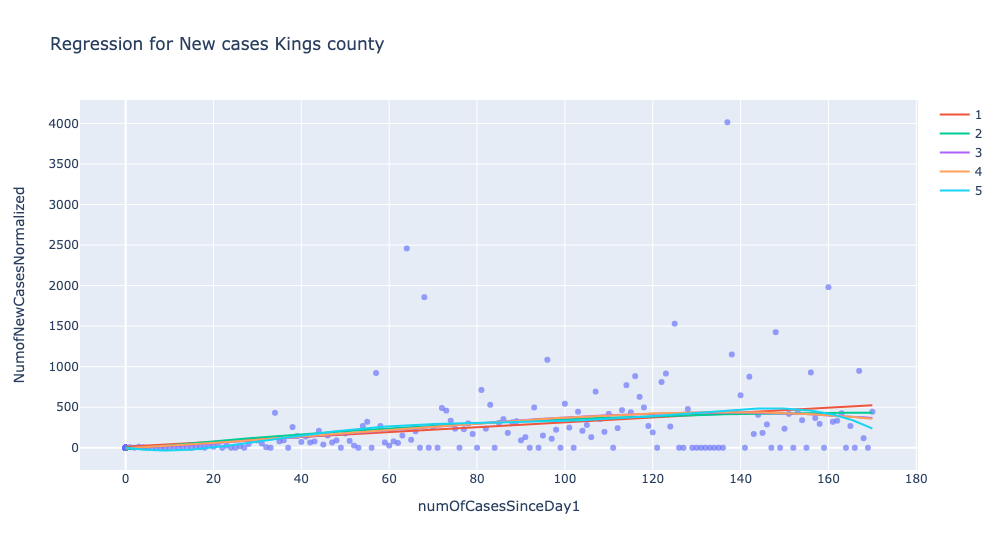

In [23]:
kings_county = COVID_CA_countys[COVID_CA_countys["countyFIPS"] == 6031].reset_index()

# Find first occurence of new case
first_case_index = kings_county['NumofNewCasesNormalized'].ne(0).idxmax() 
# Find first occurence of new death
first_death_index= kings_county['NumofNewDeathsNormalized'].ne(0).idxmax()

# Adding columns for days of 1st occurence of cases and deaths
kings_county["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_case_index, kings_county)
kings_county["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index, kings_county)

# getLRPlots(kings_county,"numOfCasesSinceDay1",'NumofNewCasesPerDay',True).show()

# Plotting Linear (degree = 1) and Polynomial Regression for new cases in kings County 
fig = getPRPlots(kings_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',True, "Regression for New cases Kings county")["fig"]
fig.write_image("../images/newcases_pred_kings_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Plotting Linear (degree = 1) and Polynomial Regression for new deaths in kings County 


RMSE for degree  1 :  5.886968184212995
R2 for degree  1 :  0.06164091109047709

RMSE for degree  2 :  6.090008185505231
R2 for degree  2 :  -0.004202828364410216

RMSE for degree  3 :  5.95812273508376
R2 for degree  3 :  0.038820326376151515

RMSE for degree  4 :  6.061871269936245
R2 for degree  4 :  0.005054925449320735

RMSE for degree  5 :  6.066078685908001
R2 for degree  5 :  0.003673305692218465



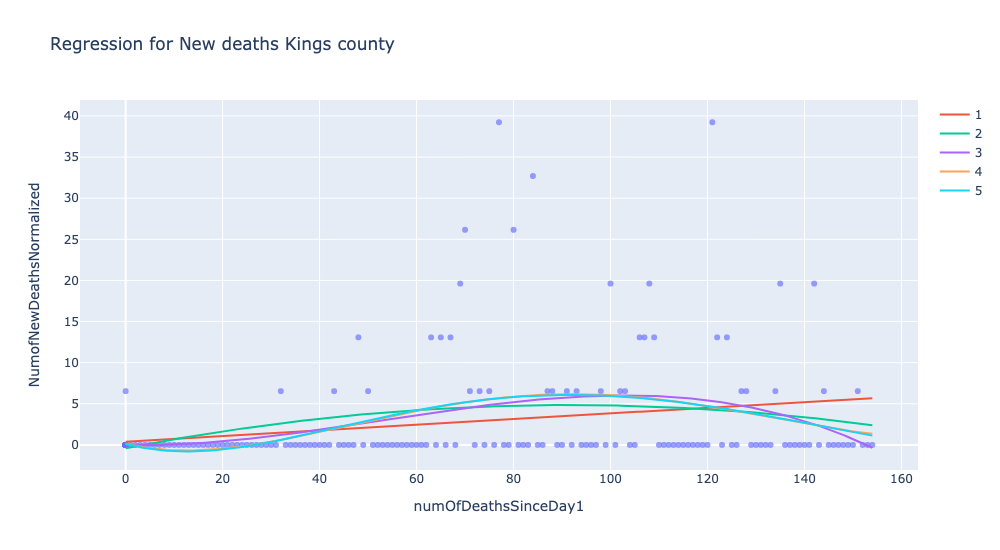

In [24]:
# Plotting Linear (degree = 1) and Polynomial Regression for new deaths in kings County 
fig = getPRPlots(kings_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',True, "Regression for New deaths Kings county")["fig"]
fig.write_image("../images/newdeaths_pred_kings_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new cases of degree 1 based on RMSE and R2 values Kings County

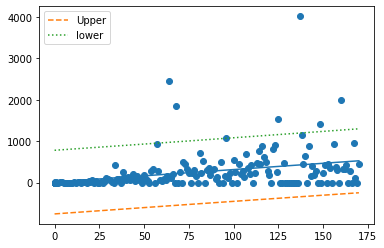

In [25]:
X = kings_county["numOfCasesSinceDay1"].values.reshape(-1,1)
y = kings_county["NumofNewCasesNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Confidence Interval for new deaths of degree 1 based on RMSE and R2 values Kings County

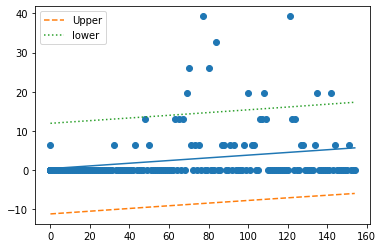

In [26]:
X = kings_county["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = kings_county["NumofNewDeathsNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting future cases for 1 week using Polynomial Regression for "Kings County"

Based on RMSE and R2 values Linear regression degree 1 for cases and deaths fits better

Cases Prediction :  [525.50734433 528.53383784 531.56033135 534.58682486 537.61331837
 540.63981188 543.66630539]


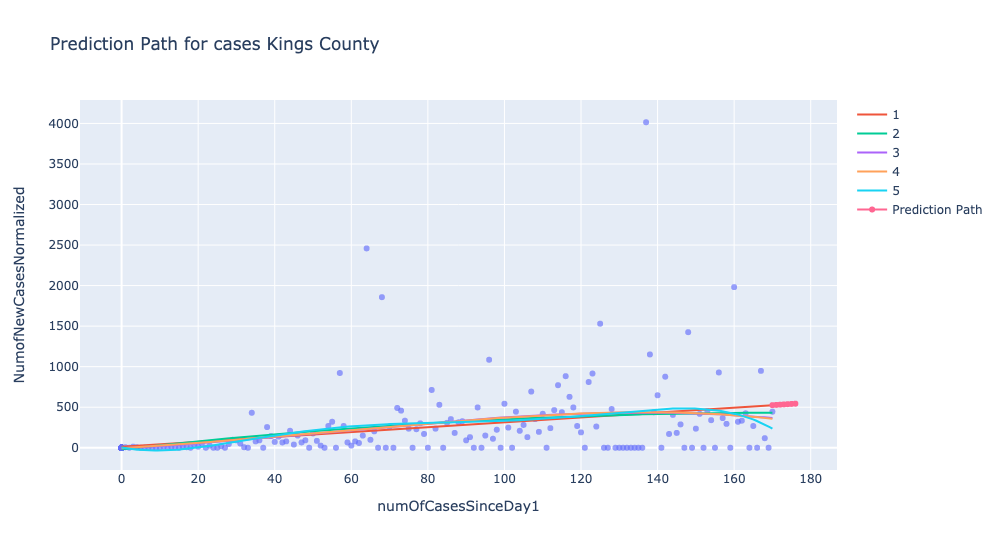

In [27]:
# X values for 7 future days
future_cases_k = np.arange(kings_county["numOfCasesSinceDay1"][len(kings_county)-1], kings_county["numOfCasesSinceDay1"][len(kings_county)-1] + 7).reshape(-1,1)
future_deaths_k = np.arange(kings_county["numOfDeathsSinceDay1"][len(kings_county)-1], kings_county["numOfDeathsSinceDay1"][len(kings_county)-1] + 7).reshape(-1,1)

# Predicting for future cases for 1 week
poly = PolynomialFeatures(degree = 1)
model = getPRPlots(kings_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path for cases Kings County")["models"][0]
poly_features = poly.fit_transform(future_cases_k)
print("Cases Prediction : ", model.predict(poly_features))

fig = getPRPlots(kings_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path for cases Kings County")["fig"]
fig.add_traces(go.Scatter(x=future_cases_k.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newcases_predpath_kings_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)


#### Predicting for future deaths for 1 week Kings County

Deaths Prediction :  [5.68683454 5.72119185 5.75554916 5.78990647 5.82426378 5.85862108
 5.89297839]


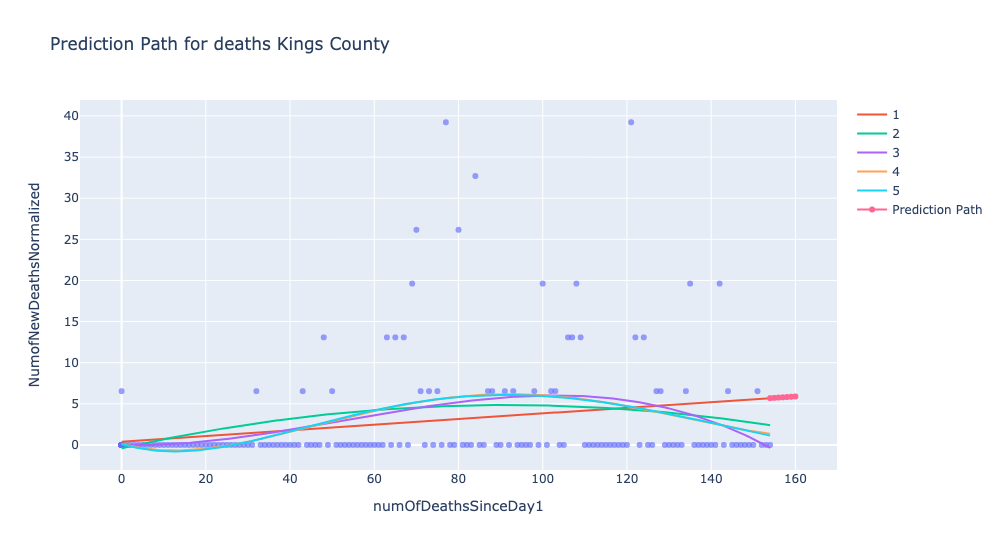

In [28]:
# Predicting for future deaths for 1 week
poly = PolynomialFeatures(degree = 1)
model = getPRPlots(kings_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path for deaths Kings County")["models"][0]
poly_features = poly.fit_transform(future_deaths_k)
print("Deaths Prediction : ",model.predict(poly_features))

fig = getPRPlots(kings_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path for deaths Kings County")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_k.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_kings_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

### Kern county

#### Linear (degree = 1) and Polynomial Regression for New cases and New deaths for "Kern county"

RMSE for degree  1 :  241.31066520143779
R2 for degree  1 :  0.21599472392290842

RMSE for degree  2 :  244.4806914985671
R2 for degree  2 :  0.1952609384782481

RMSE for degree  3 :  236.42166564089703
R2 for degree  3 :  0.2474410985049198

RMSE for degree  4 :  216.06348947779878
R2 for degree  4 :  0.37146607557939304

RMSE for degree  5 :  223.6982554855127
R2 for degree  5 :  0.32626183994070324



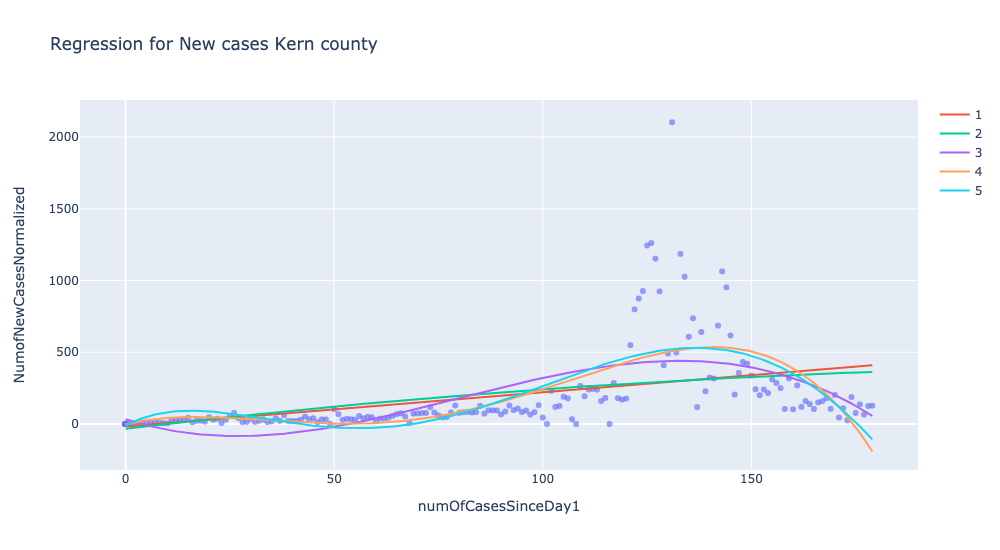

In [29]:
kern_county = COVID_CA_countys[COVID_CA_countys["countyFIPS"] == 6029].reset_index()

# Find first occurence of new case
first_case_index = kern_county['NumofNewCasesNormalized'].ne(0).idxmax() 
# Find first occurence of new death
first_death_index= kern_county['NumofNewDeathsNormalized'].ne(0).idxmax()

# Adding columns for days of 1st occurence of cases and deaths
kern_county["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_case_index, kern_county)
kern_county["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index, kern_county)

# getLRPlots(kern_county,"numOfCasesSinceDay1",'NumofNewCasesPerDay',True).show()

# Plotting Linear (degree = 1) and Polynomial Regression for new cases in Kern County 
fig = getPRPlots(kern_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',True, "Regression for New cases Kern county")["fig"]
fig.write_image("../images/newcases_pred_kern_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Plotting Linear (degree = 1) and Polynomial Regression for new deaths in Kern County 

RMSE for degree  1 :  3.1964597978577767
R2 for degree  1 :  0.16670838214691375

RMSE for degree  2 :  3.130385461789116
R2 for degree  2 :  0.2008024279768329

RMSE for degree  3 :  3.1318043113414884
R2 for degree  3 :  0.20007778999790227

RMSE for degree  4 :  3.133435149147279
R2 for degree  4 :  0.19924447928480649

RMSE for degree  5 :  3.122518003292133
R2 for degree  5 :  0.20481455527889136



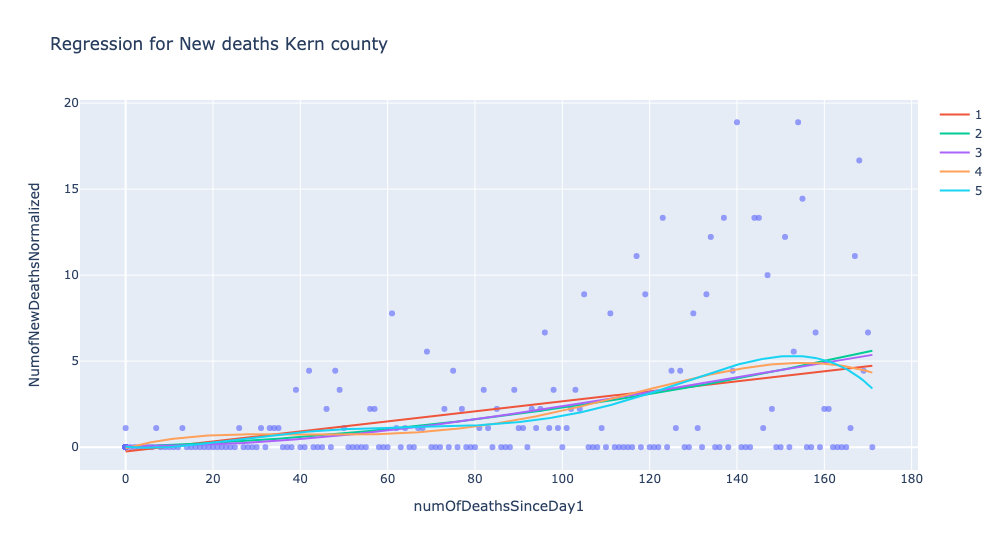

In [30]:
# Plotting Linear (degree = 1) and Polynomial Regression for new deaths in Kern County 
fig = getPRPlots(kern_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',True, "Regression for New deaths Kern county")["fig"]
fig.write_image("../images/newdeaths_pred_kern_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new cases of degree 4 based on RMSE and R2 values Kern County

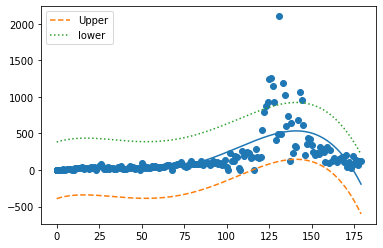

In [31]:
X = kern_county["numOfCasesSinceDay1"].values.reshape(-1,1)
y = kern_county["NumofNewCasesNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Confidence Interval for new deaths of degree 5 based on RMSE and R2 values Kern County

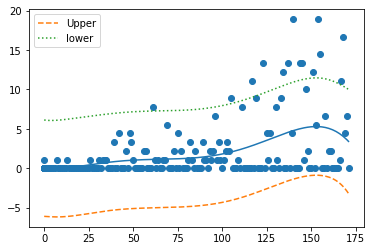

In [32]:
X = kern_county["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = kern_county["NumofNewDeathsNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=5)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting future cases for 1 week using Polynomial Regression for "Kern County"

For new cases , based on RMSE and R2 values Linear regression degree 4 for fits better

Cases Prediction :  [-191.8307916  -238.53288063 -287.11696823 -337.62180704 -390.08650061
 -444.55050337 -501.05362067]


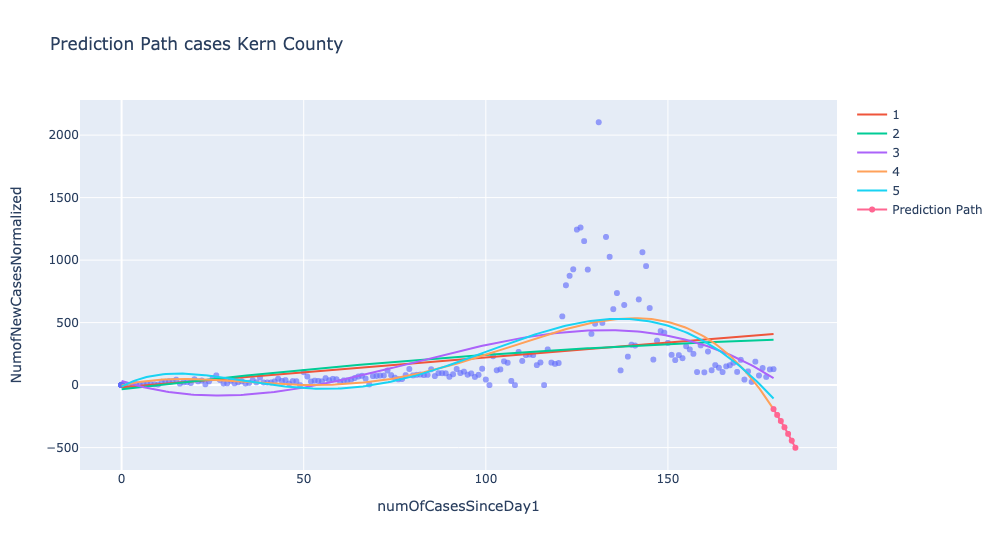

In [33]:
# X values for 7 future days
future_cases_kern = np.arange(kern_county["numOfCasesSinceDay1"][len(kern_county)-1], kern_county["numOfCasesSinceDay1"][len(kern_county)-1] + 7).reshape(-1,1)
future_deaths_kern = np.arange(kern_county["numOfDeathsSinceDay1"][len(kern_county)-1], kern_county["numOfDeathsSinceDay1"][len(kern_county)-1] + 7).reshape(-1,1)

# Predicting for future cases for 1 week
poly = PolynomialFeatures(degree = 4)
model = getPRPlots(kern_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path cases Kern County")["models"][3]
poly_features = poly.fit_transform(future_cases_kern)
print("Cases Prediction : ", model.predict(poly_features))

fig = getPRPlots(kern_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path cases Kern County")["fig"]
fig.add_traces(go.Scatter(x=future_cases_kern.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newcases_predpath_kern_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)


#### Predicting for future deaths for 1 week Kern County

For new deaths , based on RMSE and R2 values Linear regression degree 5 for fits better

Deaths Prediction :  [3.41564485 3.16487918 2.89408891 2.6024907  2.28928389 1.95365038
 1.59475437]


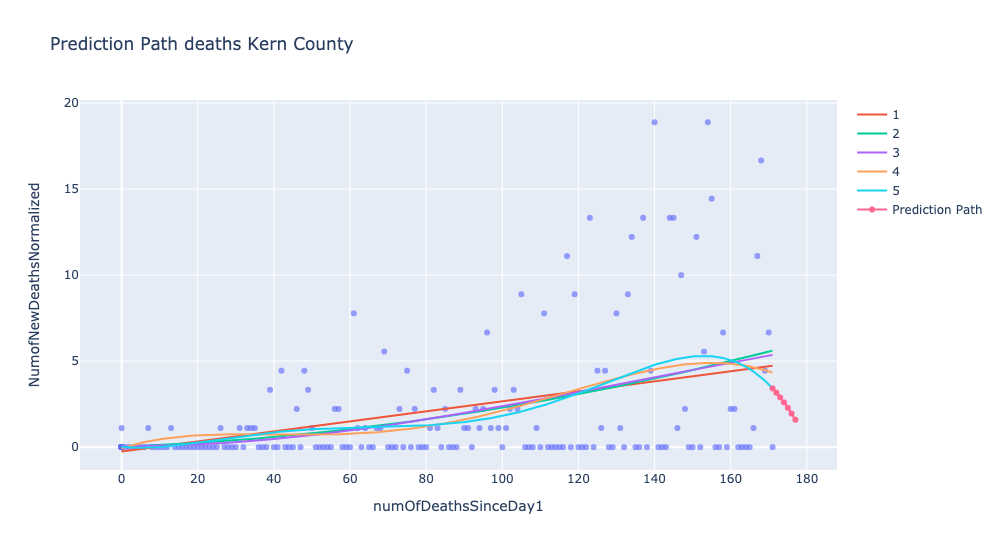

In [34]:
# Predicting for future deaths for 1 week
poly = PolynomialFeatures(degree = 5)
model = getPRPlots(kern_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path deaths Kern County")["models"][4]
poly_features = poly.fit_transform(future_deaths_kern)
print("Deaths Prediction : ",model.predict(poly_features))

fig = getPRPlots(kern_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path deaths Kern County")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_kern.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_kern_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

### Tulare county

#### Linear (degree = 1) and Polynomial Regression for New cases and New deaths for "Tulare county"

RMSE for degree  1 :  188.26216305161861
R2 for degree  1 :  0.25934480267531845

RMSE for degree  2 :  190.8657832284526
R2 for degree  2 :  0.23871697887755416

RMSE for degree  3 :  183.61009673833928
R2 for degree  3 :  0.29549658105026766

RMSE for degree  4 :  177.84109192355194
R2 for degree  4 :  0.33907189702404117

RMSE for degree  5 :  178.57107309983684
R2 for degree  5 :  0.33363496170456175



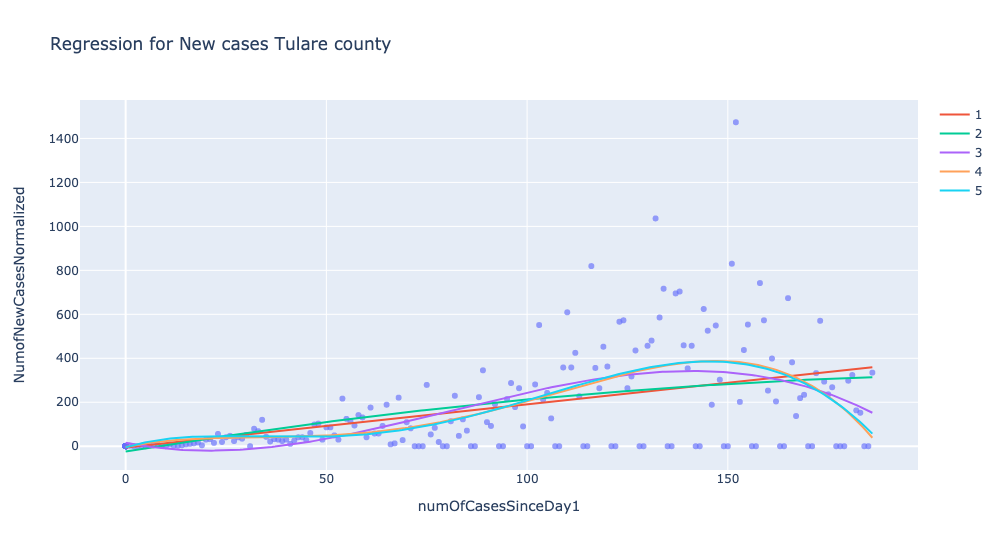

In [35]:
tulare_county = COVID_CA_countys[COVID_CA_countys["countyFIPS"] == 6107].reset_index()

# Find first occurence of new case
first_case_index = tulare_county['NumofNewCasesNormalized'].ne(0).idxmax() 
# Find first occurence of new death
first_death_index= tulare_county['NumofNewDeathsNormalized'].ne(0).idxmax()

# Adding columns for days of 1st occurence of cases and deaths
tulare_county["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_case_index, tulare_county)
tulare_county["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index, tulare_county)

# Plotting Linear (degree = 1) and Polynomial Regression for new cases in Tulare County 
fig = getPRPlots(tulare_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',True, "Regression for New cases Tulare county")["fig"]
fig.write_image("../images/newcases_pred_tulare_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

RMSE for degree  1 :  3.9755990210163366
R2 for degree  1 :  0.07671707250899473

RMSE for degree  2 :  4.018616206606271
R2 for degree  2 :  0.056628573645510105

RMSE for degree  3 :  4.078784393781276
R2 for degree  3 :  0.028168094502536323

RMSE for degree  4 :  4.132558393537098
R2 for degree  4 :  0.0023742440033797108

RMSE for degree  5 :  4.138148805213592
R2 for degree  5 :  -0.00032670317934235804



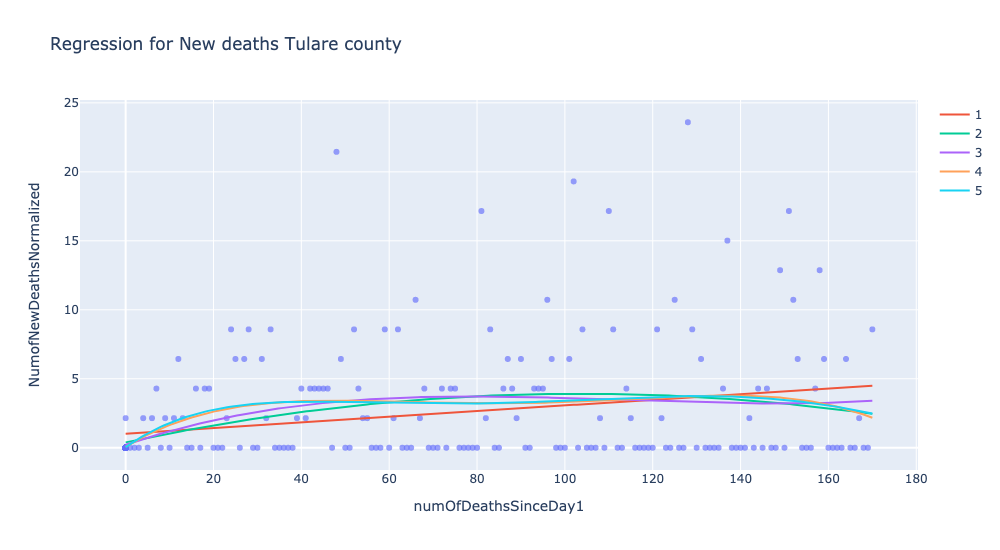

In [36]:
# Plotting Linear (degree = 1) and Polynomial Regression for new deaths in Tulare County 
fig = getPRPlots(tulare_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',True, "Regression for New deaths Tulare county")["fig"]
fig.write_image("../images/newdeaths_pred_tulare_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new cases of degree 4 based on RMSE and R2 values Tulare County

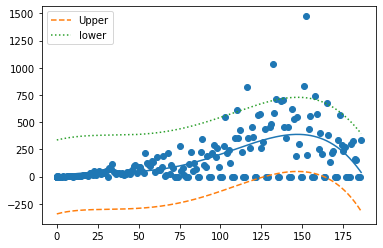

In [37]:
X = tulare_county["numOfCasesSinceDay1"].values.reshape(-1,1)
y = tulare_county["NumofNewCasesNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Confidence Interval for new deaths of degree 2 based on RMSE and R2 values Tulare County

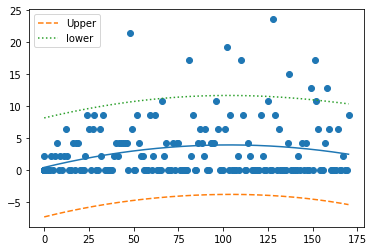

In [38]:
X = tulare_county["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = tulare_county["NumofNewDeathsNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting future cases for 1 week using Polynomial Regression for "Tulare County"

For new cases , based on RMSE and R2 values Linear regression degree 4 for fits better


Cases Prediction :  [  38.55336273   16.82366419   -5.74579424  -29.17120173  -53.46888577
  -78.65531215 -104.74708499]


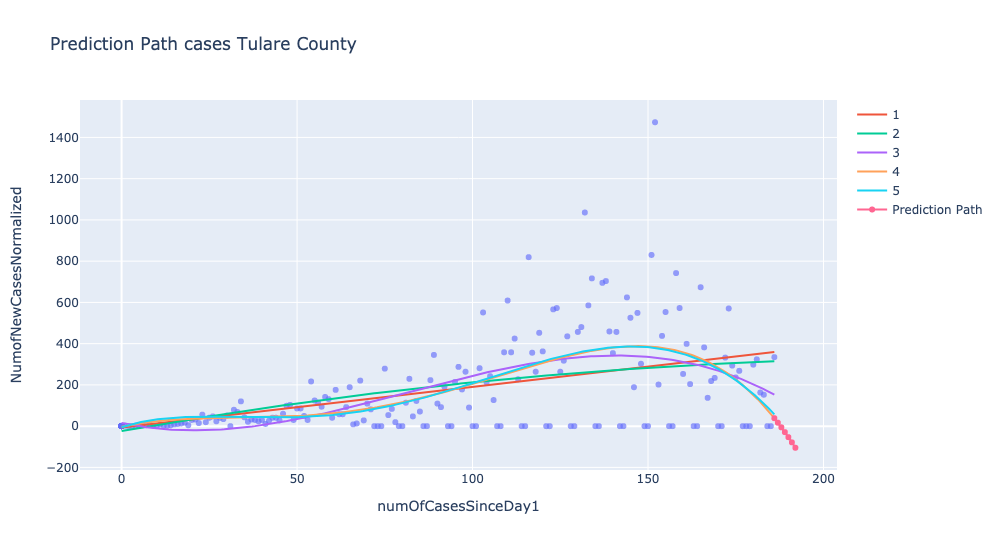

In [39]:
# X values for 7 future days
future_cases_tulare = np.arange(tulare_county["numOfCasesSinceDay1"][len(tulare_county)-1], tulare_county["numOfCasesSinceDay1"][len(tulare_county)-1] + 7).reshape(-1,1)
future_deaths_tulare = np.arange(tulare_county["numOfDeathsSinceDay1"][len(tulare_county)-1], tulare_county["numOfDeathsSinceDay1"][len(tulare_county)-1] + 7).reshape(-1,1)

# Predicting for future cases for 1 week
poly = PolynomialFeatures(degree = 4)
model = getPRPlots(tulare_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path cases Tulare County")["models"][3]
poly_features = poly.fit_transform(future_cases_tulare)
print("Cases Prediction : ", model.predict(poly_features))

fig = getPRPlots(tulare_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path cases Tulare County")["fig"]
fig.add_traces(go.Scatter(x=future_cases_tulare.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newcases_predpath_tulare_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)



#### Predicting for future deaths for 1 week using Polynomial Regression for "Tulare County"

For new deaths , based on RMSE and R2 values Polynomial regression degree 2 for fits better

Deaths Prediction :  [2.45592503 2.41175541 2.36692707 2.32144001 2.27529423 2.22848974
 2.18102653]


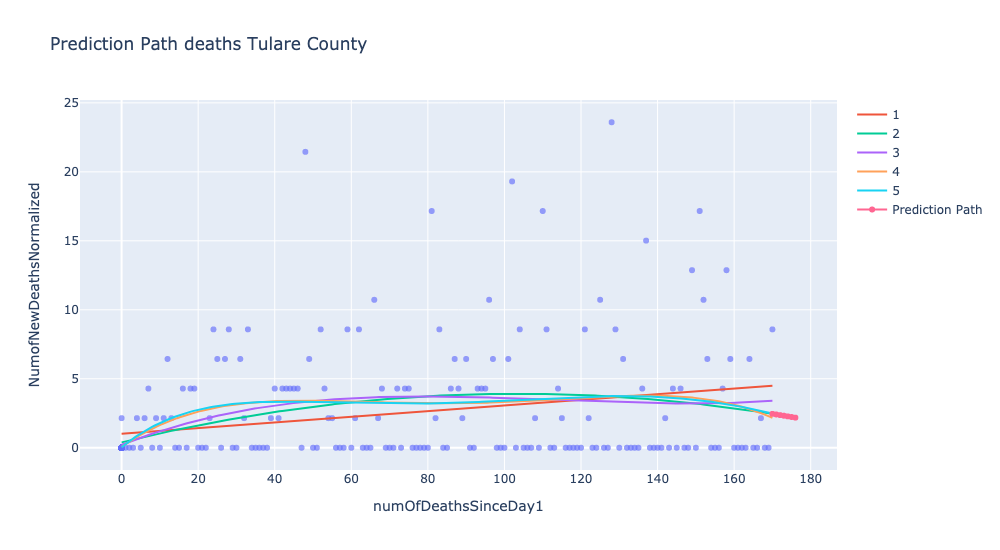

In [40]:
# Predicting for future deaths for 1 week
poly = PolynomialFeatures(degree = 2)
model = getPRPlots(tulare_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path deaths Tulare County")["models"][1]
poly_features = poly.fit_transform(future_deaths_tulare)
print("Deaths Prediction : ",model.predict(poly_features))

fig = getPRPlots(tulare_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path deaths Tulare County")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_tulare.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_tulare_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

### Merced county

#### Linear (degree = 1) and Polynomial Regression for New cases and New deaths for "Merced county"

RMSE for degree  1 :  261.9549735067215
R2 for degree  1 :  0.18227831538855843

RMSE for degree  2 :  261.85469593847085
R2 for degree  2 :  0.18290425080117445

RMSE for degree  3 :  260.0596163154592
R2 for degree  3 :  0.19406864445852645

RMSE for degree  4 :  246.69182786122448
R2 for degree  4 :  0.27479340716739864

RMSE for degree  5 :  248.26122155092912
R2 for degree  5 :  0.2655368790611695



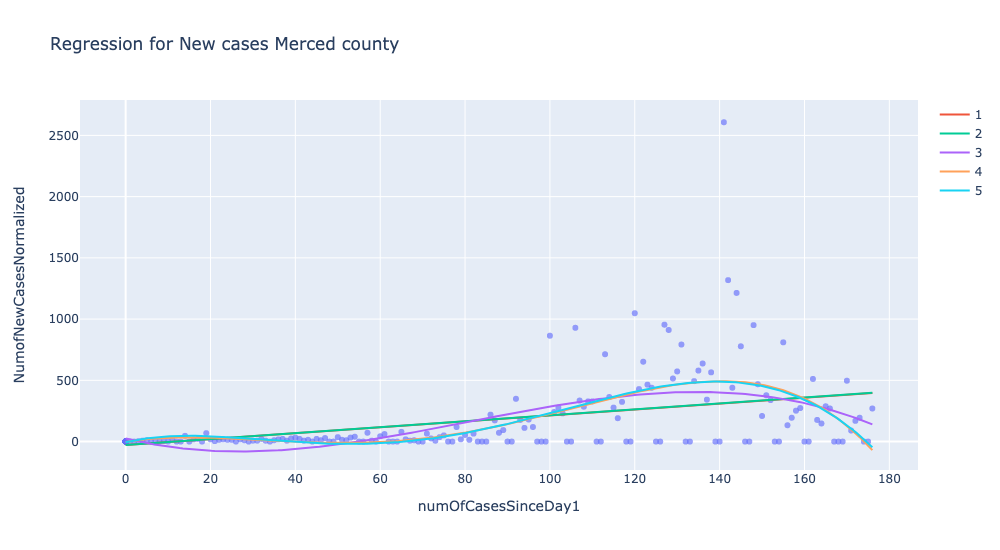

In [41]:
merced_county = COVID_CA_countys[COVID_CA_countys["countyFIPS"] == 6047].reset_index()

# Find first occurence of new case
first_case_index = merced_county['NumofNewCasesNormalized'].ne(0).idxmax() 
# Find first occurence of new death
first_death_index= merced_county['NumofNewDeathsNormalized'].ne(0).idxmax()

# Adding columns for days of 1st occurence of cases and deaths
merced_county["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_case_index, merced_county)
merced_county["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index, merced_county)

# getLRPlots(merced_county,"numOfCasesSinceDay1",'NumofNewCasesPerDay',True).show()

# Plotting Linear (degree = 1) and Polynomial Regression for new cases in Merced County 
fig = getPRPlots(merced_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',True, "Regression for New cases Merced county")["fig"]
fig.write_image("../images/newcases_pred_merced_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)



RMSE for degree  1 :  5.8484679949314415
R2 for degree  1 :  0.09595611392353998

RMSE for degree  2 :  5.769393704204679
R2 for degree  2 :  0.12023712603496217

RMSE for degree  3 :  5.866111336099052
R2 for degree  3 :  0.09049334527744268

RMSE for degree  4 :  5.754305389937937
R2 for degree  4 :  0.12483268040797557

RMSE for degree  5 :  5.728278439363612
R2 for degree  5 :  0.1327316090458628



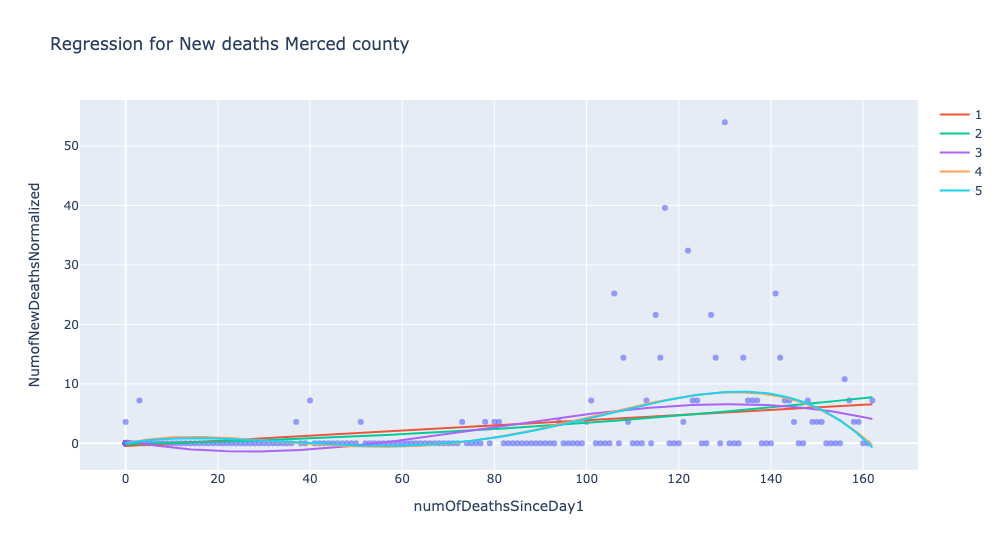

In [42]:
# Plotting Linear (degree = 1) and Polynomial Regression for new cases in Merced County 
fig = getPRPlots(merced_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',True, "Regression for New deaths Merced county")["fig"]
fig.write_image("../images/newdeaths_pred_merced_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new cases of degree 4 based on RMSE and R2 values Merced County

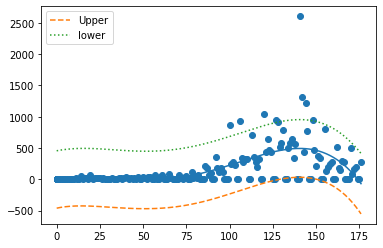

In [43]:
X = merced_county["numOfCasesSinceDay1"].values.reshape(-1,1)
y = merced_county["NumofNewCasesNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Confidence Interval for new deaths of degree 5 based on RMSE and R2 values Merced County

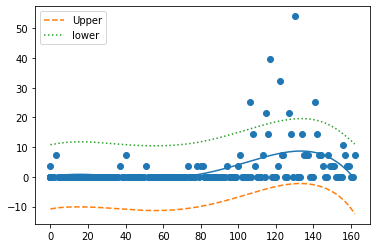

In [44]:
X = merced_county["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = merced_county["NumofNewDeathsNormalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=5)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting future cases for 1 week using Polynomial Regression for "Merced County"

For new cases , based on RMSE and R2 values Polynomial regression degree 4 for fits better

Cases Prediction :  [ -69.81776903 -108.28543551 -148.38322439 -190.14553433 -233.60708079
 -278.80289608 -325.76832935]


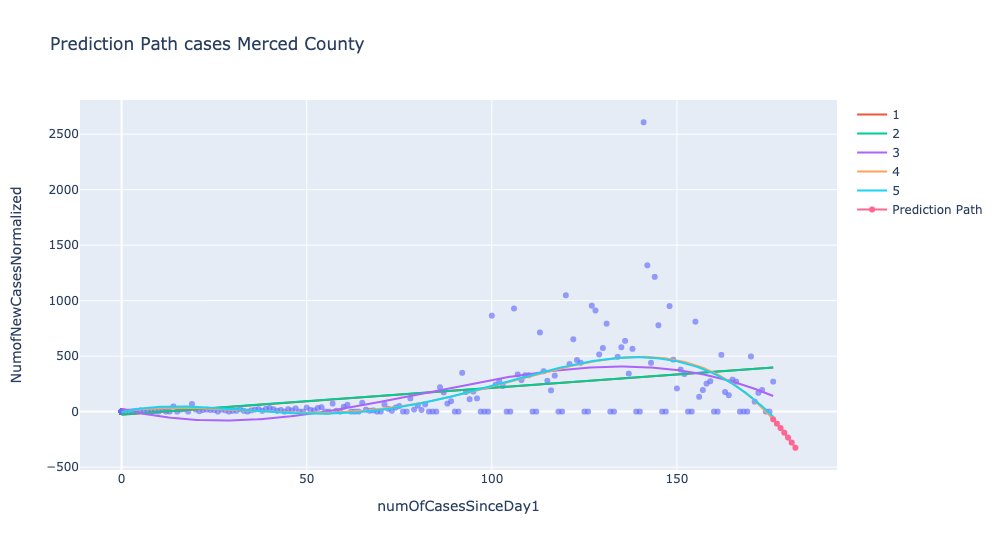

In [45]:
# X values for 7 future days
future_cases_merced = np.arange(merced_county["numOfCasesSinceDay1"][len(merced_county)-1], merced_county["numOfCasesSinceDay1"][len(merced_county)-1] + 7).reshape(-1,1)
future_deaths_merced = np.arange(merced_county["numOfDeathsSinceDay1"][len(merced_county)-1], merced_county["numOfDeathsSinceDay1"][len(merced_county)-1] + 7).reshape(-1,1)

# Predicting for future cases for 1 week
poly = PolynomialFeatures(degree = 4)
model = getPRPlots(merced_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path cases Merced County")["models"][3]
poly_features = poly.fit_transform(future_cases_merced)
print("Cases Prediction : ", model.predict(poly_features))

fig = getPRPlots(merced_county,"numOfCasesSinceDay1",'NumofNewCasesNormalized',False, "Prediction Path cases Merced County")["fig"]
fig.add_traces(go.Scatter(x=future_cases_merced.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newcases_predpath_merced_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Predicting for future deaths for 1 week using Polynomial Regression for "Merced County"

For new deaths , based on RMSE and R2 values Polynomial regression degree 5 for fits better

Deaths Prediction :  [-0.70255924 -1.50740971 -2.35534804 -3.24757932 -4.18532646 -5.16983026
 -6.20234952]


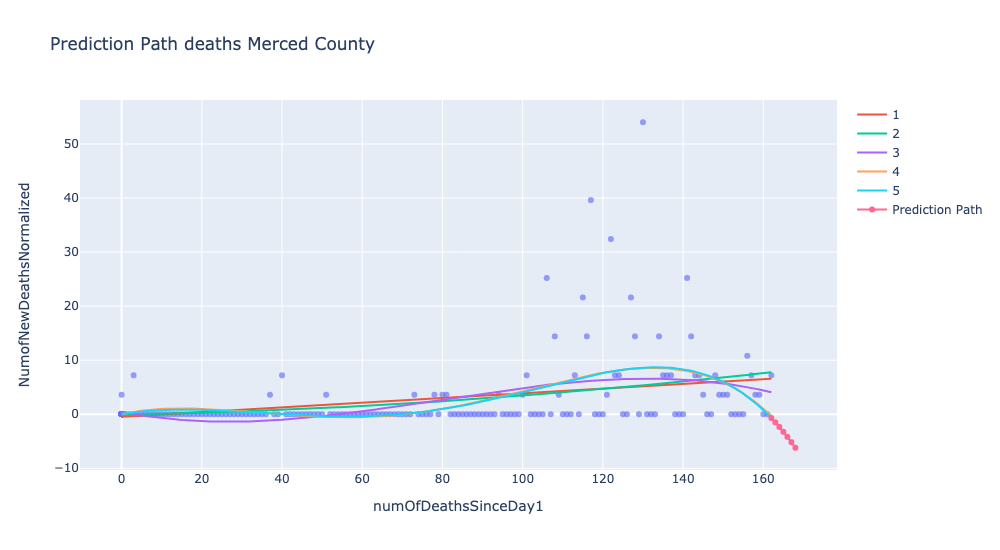

In [46]:
# Predicting for future deaths for 1 week
poly = PolynomialFeatures(degree = 5)
model = getPRPlots(merced_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path deaths Merced County")["models"][4]
poly_features = poly.fit_transform(future_deaths_merced)
print("Deaths Prediction : ",model.predict(poly_features))

fig = getPRPlots(merced_county,"numOfDeathsSinceDay1",'NumofNewDeathsNormalized',False, "Prediction Path deaths Merced County")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_merced.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_merced_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

### Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

#### Reading Hospital_beds merged data to check Total ICU beds for a state

In [47]:
enrichment_merged_data = pd.read_csv('../data/COVID_HospitalBeds_merged_df.csv')

# Considering last date in dataframe for every hospital to get total cases and deaths for that specific county
enrichment_merged_data= enrichment_merged_data[enrichment_merged_data['Date'] == '2020-09-14']

enrichment_merged_data = enrichment_merged_data.groupby(['State','countyFIPS','County Name','population','Num of Cases','Num of Deaths']).sum().reset_index()

state = enrichment_merged_data.groupby(['State']).sum().reset_index()

state=state.drop(['countyFIPS','HQ_ZIP_CODE'], axis=1)

state[state["State"].isin(["CA","NC","NY","TX","FL","VA"])]

State  population  Num of Cases  Num of Deaths  NUM_LICENSED_BEDS  \
4    CA    39508089        765446          14467              83240   
9    FL    21235208        654473          12500              62189   

   NUM_STAFFED_BEDS  NUM_ICU_BEDS  ADULT_ICU_BEDS  PEDI_ICU_BEDS  \
4             77808          8652            8652           3858   
9             55295          6231            6231           2000   

   BED_UTILIZATION  Potential_Increase_In_Bed_Capac  AVG_VENTILATOR_USAGE  
4       216.458434                             5432                  1986  
9       146.945866                             6894                  1491

#### Reading COVID data to get new deaths

In [48]:
# Get new deaths
covid_large_df['NumofNewCasesPerDay'] = covid_large_df['Num of Cases'].diff()
covid_large_df['NumofNewDeathsPerDay'] = covid_large_df['Num of Deaths'].diff()

# Removing errors
covid_large_df['NumofNewCasesPerDay'][covid_large_df['NumofNewCasesPerDay'] < 0] = 0
covid_large_df['NumofNewDeathsPerDay'][covid_large_df['NumofNewDeathsPerDay'] < 0] = 0

# Removing 1st row of date '2020-01-22'
covid_large_df = covid_large_df[covid_large_df['Date'] != '2020-01-22']

#### Extracting 5 states ("NC","NY","TX","FL","VA") 

In [49]:
COVID_5_states = covid_large_df.loc[(covid_large_df["State"].isin(["NC","NY","TX","FL","VA"]))]

COVID_5_states_bydate = COVID_5_states.groupby(["State","Date"]).sum().reset_index()

COVID_5_states_bydate.head()

State       Date  countyFIPS  Num of Cases  Num of Deaths  population  \
0    FL 2020-01-23      808550             0              0    21477737   
1    FL 2020-01-24      808550             0              0    21477737   
2    FL 2020-01-25      808550             0              0    21477737   
3    FL 2020-01-26      808550             0              0    21477737   
4    FL 2020-01-27      808550             0              0    21477737   

   NumofNewCasesPerDay  NumofNewDeathsPerDay  
0                  0.0                   0.0  
1                  0.0                   0.0  
2                  0.0                   0.0  
3                  0.0                   0.0  
4                  0.0                   0.0

#### Predicting new deaths of CA for next 7days

In [50]:
future_deaths_ca = np.arange(COVID_CA_cleaned["numOfDeathsSinceDay1"][len(COVID_CA_cleaned)-1],COVID_CA_cleaned["numOfDeathsSinceDay1"][len(COVID_CA_cleaned)-1] + 7).reshape(-1,1)
poly = PolynomialFeatures(degree = 3)
model = getPRPlots(COVID_CA_cleaned,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False,"")["models"][2]
poly_features = poly.fit_transform(future_deaths_ca)
model.predict(poly_features)

array([113.37783921, 113.30799552, 113.22750813, 113.13630775,
       113.0343251 , 112.92149089, 112.79773582])

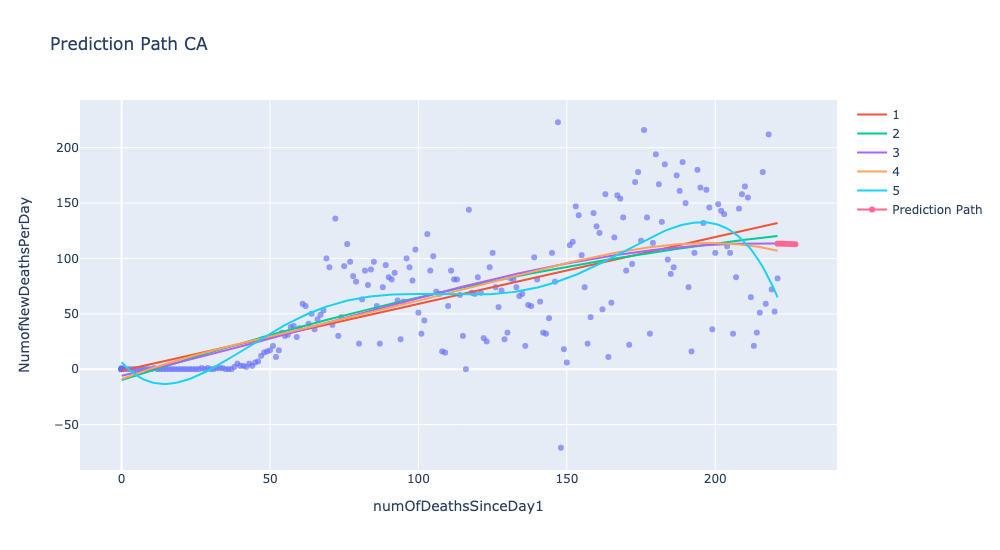

In [51]:
fig = getPRPlots(COVID_CA_cleaned,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False, "Prediction Path CA")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_ca.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

For CA state Total ICU Beds - 8652, so the predicted values for next 7 days are very less compared to ICU Beds. Therefore, CA state is doing fine for the next week

#### Regression on new deaths of NC State

RMSE for degree  1 :  12.700779341262527
R2 for degree  1 :  0.2852713718211777

RMSE for degree  2 :  13.051356691483422
R2 for degree  2 :  0.24526975473388113

RMSE for degree  3 :  13.428275643885508
R2 for degree  3 :  0.20104755289955267

RMSE for degree  4 :  14.056323103906557
R2 for degree  4 :  0.12456501318653135

RMSE for degree  5 :  13.967425903129111
R2 for degree  5 :  0.13560312418273157



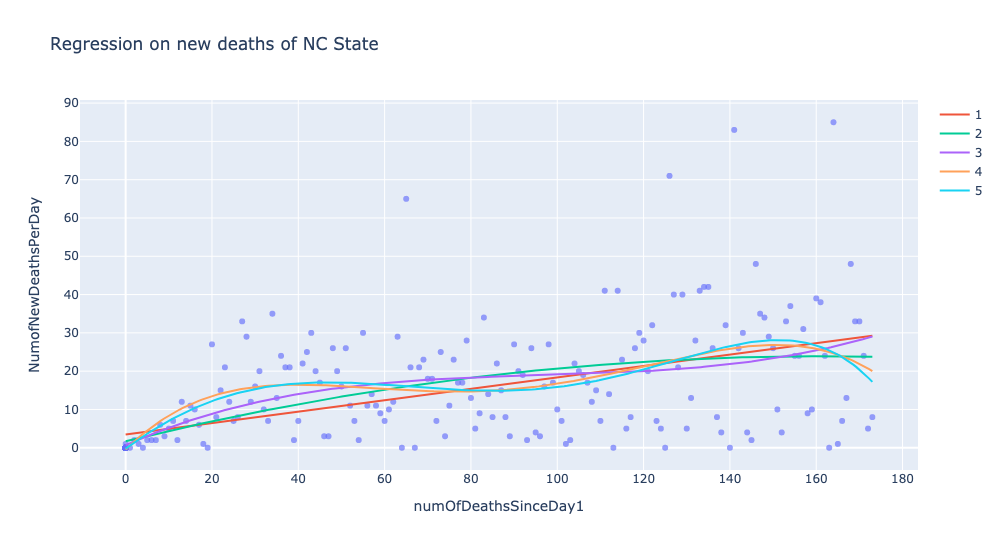

In [52]:
NC_State = COVID_5_states_bydate[COVID_5_states_bydate["State"] == "NC"].reset_index()

first_cases_index_nc = NC_State['NumofNewCasesPerDay'].ne(0).idxmax()
first_death_index_nc = NC_State['NumofNewDeathsPerDay'].ne(0).idxmax()

NC_State["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_cases_index_nc,NC_State)
NC_State["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index_nc,NC_State)

fig = getPRPlots(NC_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',True,"Regression on new deaths of NC State")["fig"]
fig.write_image("../images/newdeaths_nc_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new deaths of degree 2 based on RMSE and R2 values NC State

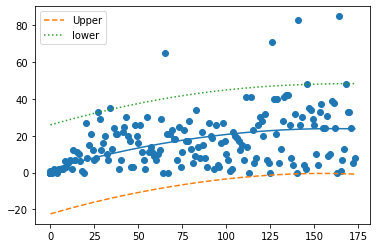

In [53]:
X = NC_State["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = NC_State["NumofNewDeathsPerDay"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting new deaths of NC for next 7days

In [54]:
future_deaths_nc = np.arange(NC_State["numOfDeathsSinceDay1"][len(NC_State)-1],NC_State["numOfDeathsSinceDay1"][len(NC_State)-1] + 7).reshape(-1,1)
poly = PolynomialFeatures(degree = 2)
model = getPRPlots(NC_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False,"")["models"][1]
poly_features = poly.fit_transform(future_deaths_nc)
model.predict(poly_features)

array([23.7527702 , 23.73109093, 23.70769756, 23.68259009, 23.6557685 ,
       23.62723282, 23.59698302])

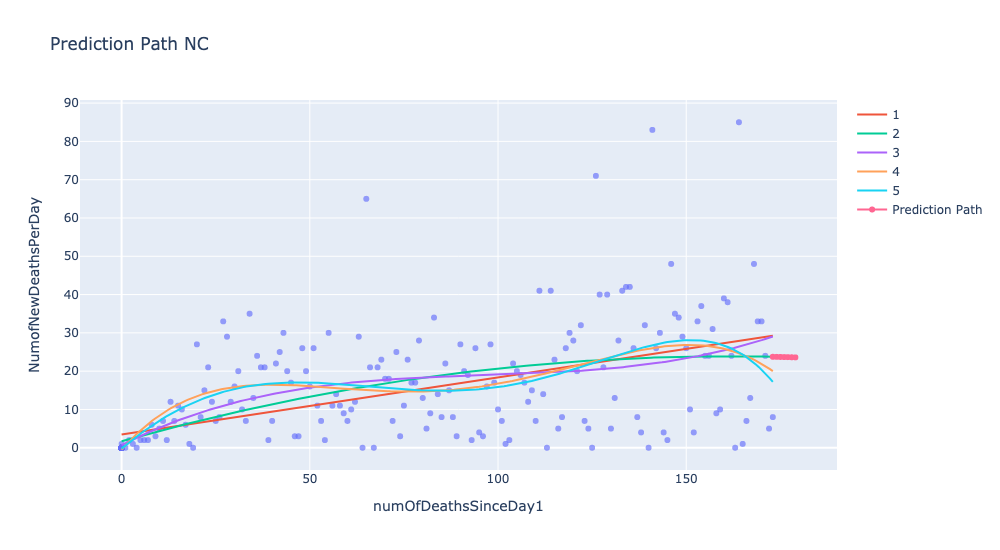

In [55]:
fig = getPRPlots(NC_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False, "Prediction Path NC")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_nc.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_nc_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

For NC state Total ICU Beds - 2648, so the predicted values for next 7 days are very less compared to ICU Beds. and we can see it is almost stable as all the values for next week is around 23. Therefore, NC state is doing fine for the next week

#### Regression on new deaths of NY State

RMSE for degree  1 :  277.28564461895
R2 for degree  1 :  0.02017754694753504

RMSE for degree  2 :  257.5001421637602
R2 for degree  2 :  0.15501779872793398

RMSE for degree  3 :  276.80023375097136
R2 for degree  3 :  0.02360506059019485

RMSE for degree  4 :  339.0345750454159
R2 for degree  4 :  -0.464807635623975

RMSE for degree  5 :  353.9235350349638
R2 for degree  5 :  -0.5962889265710649



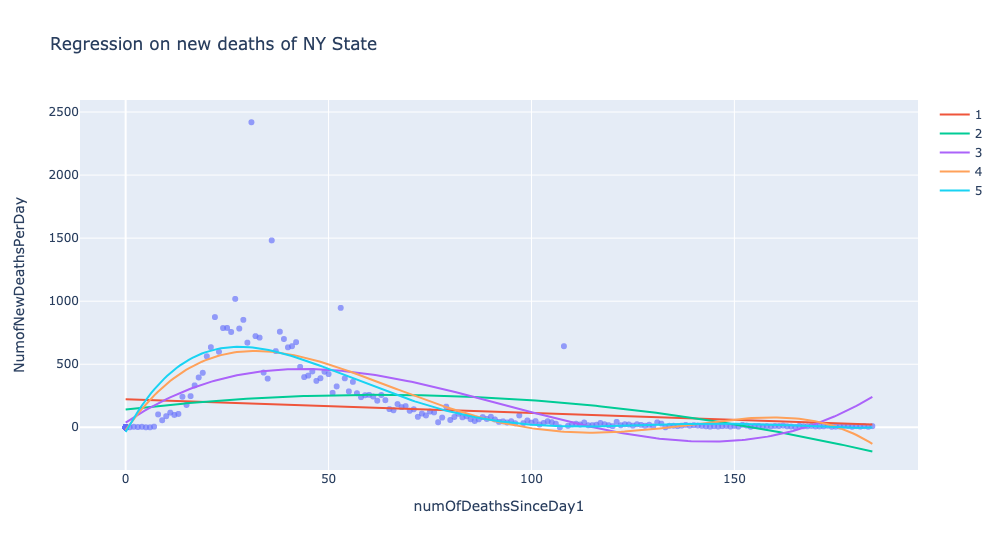

In [56]:
NY_State = COVID_5_states_bydate[COVID_5_states_bydate["State"] == "NY"].reset_index()
first_death_index_ny = NY_State['NumofNewDeathsPerDay'].ne(0).idxmax()
NY_State["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index_ny,NY_State)
fig = getPRPlots(NY_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',True, "Regression on new deaths of NY State")["fig"]
fig.write_image("../images/newdeaths_ny_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new deaths of degree 2 based on RMSE and R2 values NY State

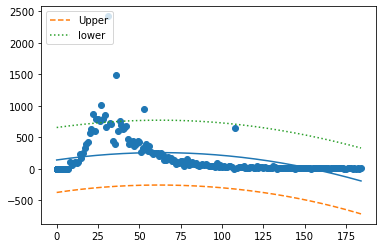

In [57]:
X = NY_State["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = NY_State["NumofNewDeathsPerDay"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting new deaths of NY for next 7days

In [58]:
future_deaths_ny = np.arange(NY_State["numOfDeathsSinceDay1"][len(NY_State)-1],NY_State["numOfDeathsSinceDay1"][len(NY_State)-1] + 7).reshape(-1,1)
poly = PolynomialFeatures(degree = 2)
model = getPRPlots(NY_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False,"")["models"][1]
poly_features = poly.fit_transform(future_deaths_ny)
model.predict(poly_features)

array([-191.99393722, -199.40040161, -206.86740214, -214.3949388 ,
       -221.98301159, -229.63162051, -237.34076555])

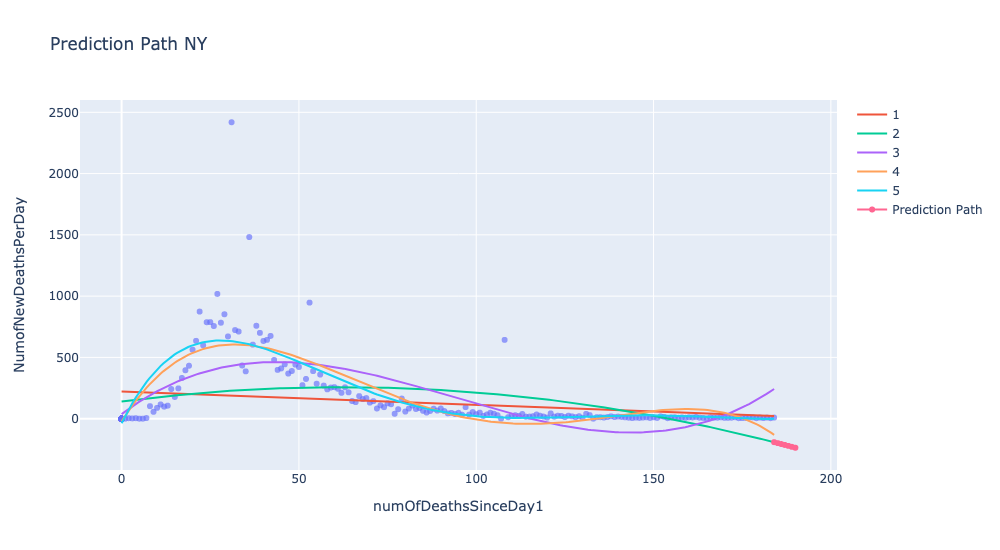

In [59]:
fig = getPRPlots(NY_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False, "Prediction Path NY")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_ny.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_ny_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

For NY state Total ICU Beds - 4230, so the predicted values for next 7 days are very less compared to ICU Beds. Therefore, NY state is doing fine for the next week

#### Regression on new deaths of TX State

RMSE for degree  1 :  94.2514785624725
R2 for degree  1 :  0.25879721815220935

RMSE for degree  2 :  91.80732827335756
R2 for degree  2 :  0.29674084453058436

RMSE for degree  3 :  92.04633624856966
R2 for degree  3 :  0.29307439779550515

RMSE for degree  4 :  89.63714153612973
R2 for degree  4 :  0.32959584955023924

RMSE for degree  5 :  87.10272650576782
R2 for degree  5 :  0.36697014020740837



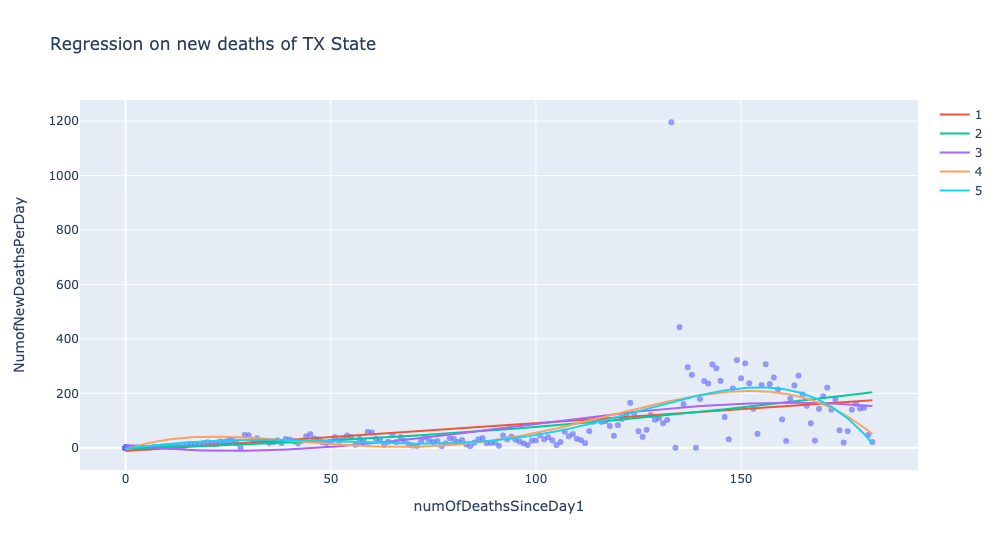

In [60]:
TX_State = COVID_5_states_bydate[COVID_5_states_bydate["State"] == "TX"].reset_index()
first_cases_index_tx = TX_State['NumofNewCasesPerDay'].ne(0).idxmax()
first_death_index_tx = TX_State['NumofNewDeathsPerDay'].ne(0).idxmax()

TX_State["numOfCasesSinceDay1"] = getDaysSinceFirstOcc(first_cases_index_tx,TX_State)
TX_State["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index_tx,TX_State)

fig = getPRPlots(TX_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',True,"Regression on new deaths of TX State")["fig"]
fig.write_image("../images/newdeaths_pred_tx_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new deaths of degree 5 based on RMSE and R2 values TX State

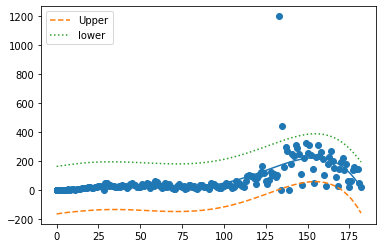

In [61]:
X = TX_State["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = TX_State["NumofNewDeathsPerDay"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=5)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting new deaths of TX for next 7days

In [62]:
future_deaths_tx = np.arange(TX_State["numOfDeathsSinceDay1"][len(TX_State)-1],TX_State["numOfDeathsSinceDay1"][len(TX_State)-1] + 7).reshape(-1,1)
poly = PolynomialFeatures(degree = 5)
model = getPRPlots(TX_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False,"")["models"][4]
poly_features = poly.fit_transform(future_deaths_tx)
model.predict(poly_features)

array([  16.01950252,   -2.64048853,  -22.36997331,  -43.20226142,
        -65.17125494,  -88.3114532 , -112.65795756])

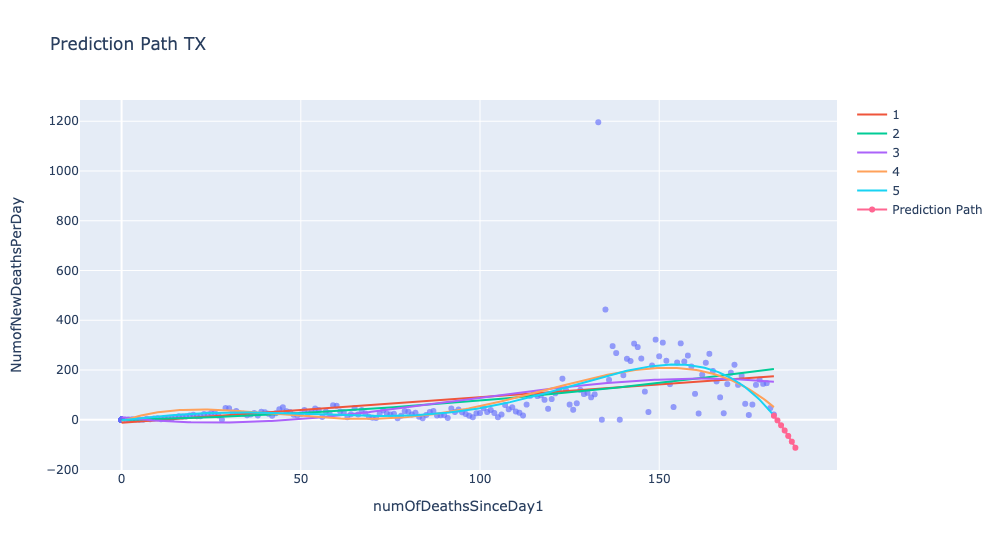

In [63]:
fig = getPRPlots(TX_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False, "Prediction Path TX")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_tx.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_tx_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

For TX state Total ICU Beds - 8719, so the predicted values for next 7 days are very less compared to ICU Beds. Therefore, TX state is doing fine for the next week

#### Regression on new deaths of FL State

RMSE for degree  1 :  94.2514785624725
R2 for degree  1 :  0.25879721815220935

RMSE for degree  2 :  91.80732827335756
R2 for degree  2 :  0.29674084453058436

RMSE for degree  3 :  92.04633624856966
R2 for degree  3 :  0.29307439779550515

RMSE for degree  4 :  89.63714153612973
R2 for degree  4 :  0.32959584955023924

RMSE for degree  5 :  87.10272650576782
R2 for degree  5 :  0.36697014020740837



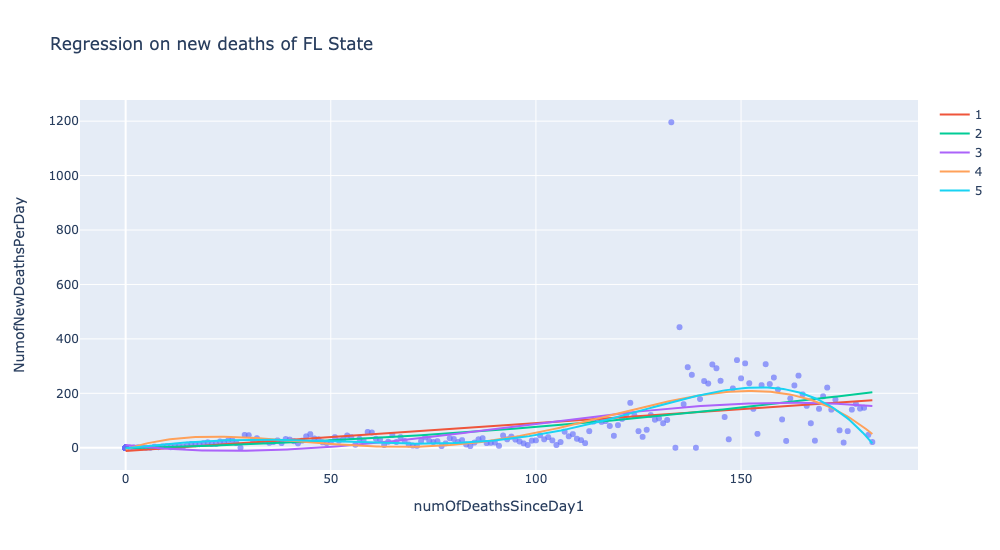

In [64]:
FL_State = COVID_5_states_bydate[COVID_5_states_bydate["State"] == "FL"].reset_index()
first_death_index_fl = FL_State['NumofNewDeathsPerDay'].ne(0).idxmax()
FL_State["numOfDeathsSinceDay1"] = getDaysSinceFirstOcc(first_death_index_fl,FL_State)
fig = getPRPlots(TX_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',True,"Regression on new deaths of FL State")["fig"]
fig.write_image("../images/newdeaths_pred_fl_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

#### Confidence Interval for new deaths of degree 5 based on RMSE and R2 values FL State

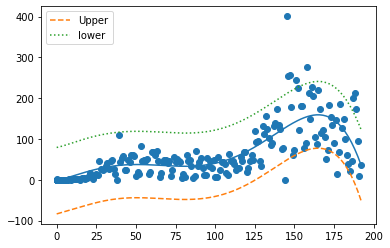

In [65]:
X = FL_State["numOfDeathsSinceDay1"].values.reshape(-1,1)
y = FL_State["NumofNewDeathsPerDay"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=5)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### Predicting new deaths of FL for next 7days

In [66]:
future_deaths_fl = np.arange(FL_State["numOfDeathsSinceDay1"][len(FL_State)-1],FL_State["numOfDeathsSinceDay1"][len(FL_State)-1] + 7).reshape(-1,1)
poly = PolynomialFeatures(degree = 3)
model = getPRPlots(FL_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False,"")["models"][2]
poly_features = poly.fit_transform(future_deaths_fl)
model.predict(poly_features)

array([126.79274728, 126.65191719, 126.48587768, 126.29436272,
       126.07710624, 125.8338422 , 125.56430455])

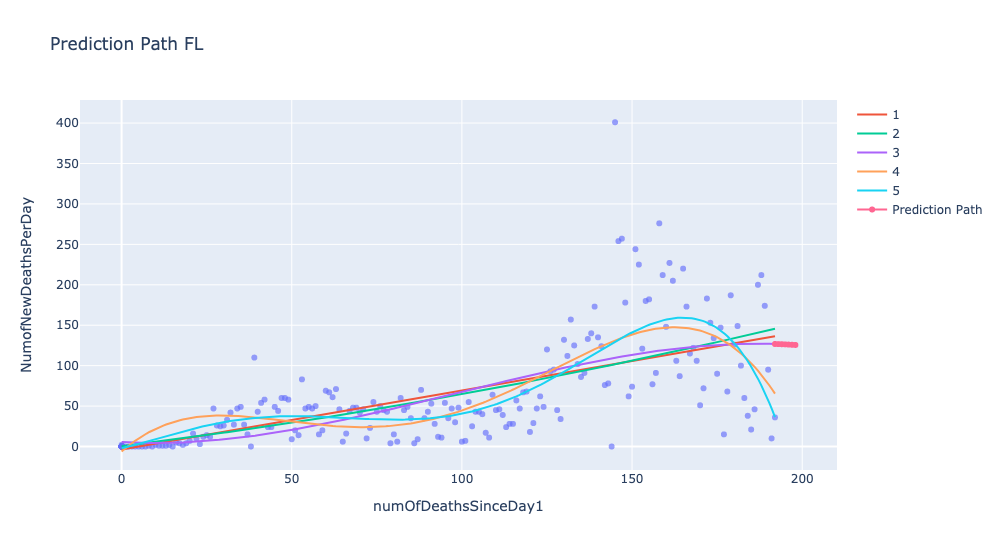

In [67]:
fig = getPRPlots(FL_State,"numOfDeathsSinceDay1",'NumofNewDeathsPerDay',False, "Prediction Path FL")["fig"]
fig.add_traces(go.Scatter(x=future_deaths_fl.squeeze(), y=model.predict(poly_features), name='Prediction Path'))
fig.write_image("../images/newdeaths_predpath_fl_ca.png")
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=1)
Image(img_bytes)

For FL state Total ICU Beds - 6231, so the predicted values for next 7 days are very less compared to ICU Beds. Therefore, FL state is doing fine for the next week

### Utilize decision tree, random forest, and ARIMA based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.

### Decision Tree

#### Taking training data until previous week, where x is days and y is new cases

In [68]:
# x is days from 1st occurence of new case
x = COVID_CA_cleaned.iloc[:len(COVID_CA_cleaned)-7]["numOfCasesSinceDay1"].values.reshape(-1,1)

# y is new cases
y = COVID_CA_cleaned.iloc[:len(COVID_CA_cleaned)-7]["NumofNewCasesPerDay"].values.reshape(-1,1)

#### Fitting the model

In [69]:
# Fitting the model
from sklearn.tree import DecisionTreeRegressor
DecisionTreeRegModel = DecisionTreeRegressor()
DecisionTreeRegModel.fit(x,y)

DecisionTreeRegressor()

#### Predicting new cases for last week

In [70]:
# Getting last week days
check  = COVID_CA_cleaned.tail(7)["numOfCasesSinceDay1"].values.reshape(-1,1)
# future_cases = np.arange(COVID_CA_cleaned["numOfCasesSinceDay1"][len(COVID_CA_cleaned)-1],COVID_CA_cleaned["numOfCasesSinceDay1"][len(COVID_CA_cleaned)-1] + 7).reshape(-1,1)
# Predicting y_test 
y_pred = DecisionTreeRegModel.predict(check)


#### Calculating RMSE

In [71]:
mse = mean_squared_error(COVID_CA_cleaned["NumofNewCasesPerDay"].tail(7).values.reshape(-1,1),y_pred)
np.sqrt(mse)

1774.6035774625434

### Random Forest

In [72]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x, y.ravel())

RandomForestRegressor(n_estimators=1000, random_state=42)

#### Predicting new cases for last week

In [73]:
predictions = rf.predict(check)

#### Calculating RMSE

In [74]:
mse = mean_squared_error(COVID_CA_cleaned["NumofNewCasesPerDay"].tail(7).values.reshape(-1,1),predictions)
np.sqrt(mse)

1648.2039652760993

#### ARIMA

#### Getting Date and new cases

In [75]:
series = COVID_CA_cleaned[["Date","NumofNewCasesPerDay"]]

#### Taking training data until previous week, where train is new cases until previous week and test is new cases for last week

In [76]:
train = series["NumofNewCasesPerDay"].iloc[:len(series)-7]
test = series["NumofNewCasesPerDay"].tail(7).values

#### Using auto_arima to get best model

In [77]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3995.325, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4066.035, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4045.834, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3997.677, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4064.045, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3993.435, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3991.241, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3992.243, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3993.707, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3991.844, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3991.073, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3996.141, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3992.184, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3993.581, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]          

#### Fitting the model with the p =5, d =1 , q = 5

In [78]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(5,1,5))
model_fit = model.fit()
print(model_fit.summary())

                               ARIMA Model Results                               
Dep. Variable:     D.NumofNewCasesPerDay   No. Observations:                  228
Model:                    ARIMA(5, 1, 5)   Log Likelihood               -1957.864
Method:                          css-mle   S.D. of innovations           1289.268
Date:                   Sun, 15 Nov 2020   AIC                           3939.728
Time:                           23:24:41   BIC                           3980.880
Sample:                                1   HQIC                          3956.332
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          16.4488     25.403      0.648      0.517     -33.339      66.237
ar.L1.D.NumofNewCasesPerDay     0.2680      0.100      2

#### Predicting last week of data

In [79]:
predictions = list()
history = [x for x in train]

for t in range(len(test)):
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=4461.684012, expected=3098.000000
predicted=4461.684012, expected=4661.000000
predicted=4461.684012, expected=2253.000000
predicted=4461.684012, expected=5433.000000
predicted=4461.684012, expected=3009.000000
predicted=4461.684012, expected=1986.000000
predicted=4461.684012, expected=4985.000000


#### Calculating RMSE value

In [80]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('RMSE:', np.sqrt(error))

Test MSE: 2319180.365
RMSE: 1522.8855389982248


Comparing all 3 models, the RMSE score for ARIMA is less

### Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county. Compare Random Forest and Decision Trees (RMSE error).

#### Reading Hospital Beds merged data

In [81]:
hospital_covid = pd.read_csv('../data/COVID_HospitalBeds_merged_df.csv')

# Considering last date in dataframe for every hospital to get total cases and deaths for that specific county
hospital_covid = hospital_covid[hospital_covid['Date'] == '2020-09-14']

hospital_covid = hospital_covid.groupby(['State','countyFIPS','County Name','population','Num of Cases','Num of Deaths']).sum().reset_index()

# Grouping by county
merged_data = hospital_covid[(hospital_covid["State"] == "CA")].groupby(['countyFIPS','County Name','population']).sum().reset_index()


#### Data for training and testing models

In [82]:
x = merged_data[["NUM_LICENSED_BEDS","NUM_STAFFED_BEDS","NUM_ICU_BEDS","AVG_VENTILATOR_USAGE","BED_UTILIZATION"]]
y_cases = merged_data["Num of Cases"]
y_deaths = merged_data["Num of Deaths"]

# X_train is enrichment data until previous week
X_train = x.iloc[:len(merged_data)-7]

# y_train_cases is new cases until previous week
y_train_cases = y_cases.iloc[:len(merged_data)-7]

# y_train_deaths is new deaths until previous week
y_train_deaths = y_deaths.iloc[:len(merged_data)-7]

# X_test is enrichment data for last week
X_test = x.tail(7)

# y_test_cases is new cases for last week
y_test_cases = y_cases.tail(7)

# y_train_deaths is new deaths for last week
y_test_deaths = y_deaths.tail(7)

#### DecisionTree Regressor Cases

In [98]:
# define dataset
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train_cases)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i+1,v))

Feature: 1, Score: 0.00102
Feature: 2, Score: 0.03062
Feature: 3, Score: 0.00355
Feature: 4, Score: 0.86082
Feature: 5, Score: 0.10399


#### Predicting X_test for cases

In [84]:
y_pred = model.predict(X_test)

#### Calculation of RMSE for cases

In [85]:
mse = mean_squared_error(y_test_cases,y_pred)
np.sqrt(mse)

8616.181230684508

#### RandomForest Regressor

In [86]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train_cases)
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i+1,v))

Feature: 1, Score: 0.15589
Feature: 2, Score: 0.15631
Feature: 3, Score: 0.15812
Feature: 4, Score: 0.19929
Feature: 5, Score: 0.33039


#### Predicting X_test

In [87]:
predictions = rf.predict(X_test)

#### Calculation of RMSE

In [88]:
mse = mean_squared_error(y_test_cases,predictions)
np.sqrt(mse)

4449.961666444892

RMSE for Random Forest is less compared to decision tree. On observing feature importance from both models we can say Feature 4 (AVG_VENTILATOR_USAGE) and Feature 5 (BED_UTILIZATION) has high importance for cases


#### DecisionTree Regressor Deaths

In [89]:
# define dataset
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train_deaths)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i+1,v))

Feature: 1, Score: 0.00126
Feature: 2, Score: 0.01374
Feature: 3, Score: 0.00118
Feature: 4, Score: 0.91463
Feature: 5, Score: 0.06919


#### Predicting X_test for deaths

In [90]:
y_pred = model.predict(X_test)

#### Calculation of RMSE for deaths

In [91]:
mse = mean_squared_error(y_test_deaths,y_pred)
np.sqrt(mse)

105.22357150372724

#### RandomForest Regressor Deaths

In [92]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train_deaths)
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i+1,v))

Feature: 1, Score: 0.17352
Feature: 2, Score: 0.16144
Feature: 3, Score: 0.14382
Feature: 4, Score: 0.21242
Feature: 5, Score: 0.30880


#### Predicting X_test for deaths

In [93]:
predictions = rf.predict(X_test)

#### Calculation of RMSE for deaths

In [94]:
mse = mean_squared_error(y_test_deaths,predictions)
np.sqrt(mse)

85.00191157598415

RMSE for Random Forest is less compared to decision tree. On observing feature importance from both models we can say Feature 4 (AVG_VENTILATOR_USAGE) and Feature 5 (BED_UTILIZATION) has high importance for deaths as well
